# Initialization

## Import

In [32]:
import matplotlib.pyplot as plt
import model_tune_helpers.lgbm_optuna.feature_importance_extractor as feat_imp_ext
import jupiter_experiments.tuner as tuner
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import model_tune_helpers.ts_splitter as ts_splitter
import shap
import settings.settings as settings
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Constants

In [33]:
pol_id = 6001
METRIC = 'rmse'
OBJECTIVE = 'regression'
OPTIMIZATION_DIRECTION = 'minimize'
CATEGORIES = [[], ['season'], ['month'], ['year'], ['season', 'month'], ['season', 'month', 'year'], ['season', 'month', 'weekday']]

TRAIN_DATE_FROM = '2015-04-01'
TRAIN_DATE_TO = '2023-04-30'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_TO = '2023-05-07'

CSV_CONC_PREV_FILE = '../../datasets/pollutants-clean-data/prev_years/6001.csv'
CSV_CONC_CUR_FILE = '../../datasets/pollutants-clean-data/cur_year/6001.csv'

CSV_WEATHER_PREV_FILE = '../../datasets/weather-clean-data/weather_prev_years.csv'
CSV_WEATHER_CUR_FILE = '../../datasets/weather-clean-data/weather_cur_year.csv'

CSV_JOINT_FILE = '../datasources/ds_joint/ds.csv'
CSV_SCORE_FILE = '../datasources/pm25_scores/score.csv'

categories=[['month', 'weekday'], ['month']]
use_aqi_cols = True

## Source data load

### Source data update

<Axes: title={'center': 'Concentration PM2.5'}, xlabel='DatetimeEnd', ylabel='Concentration'>

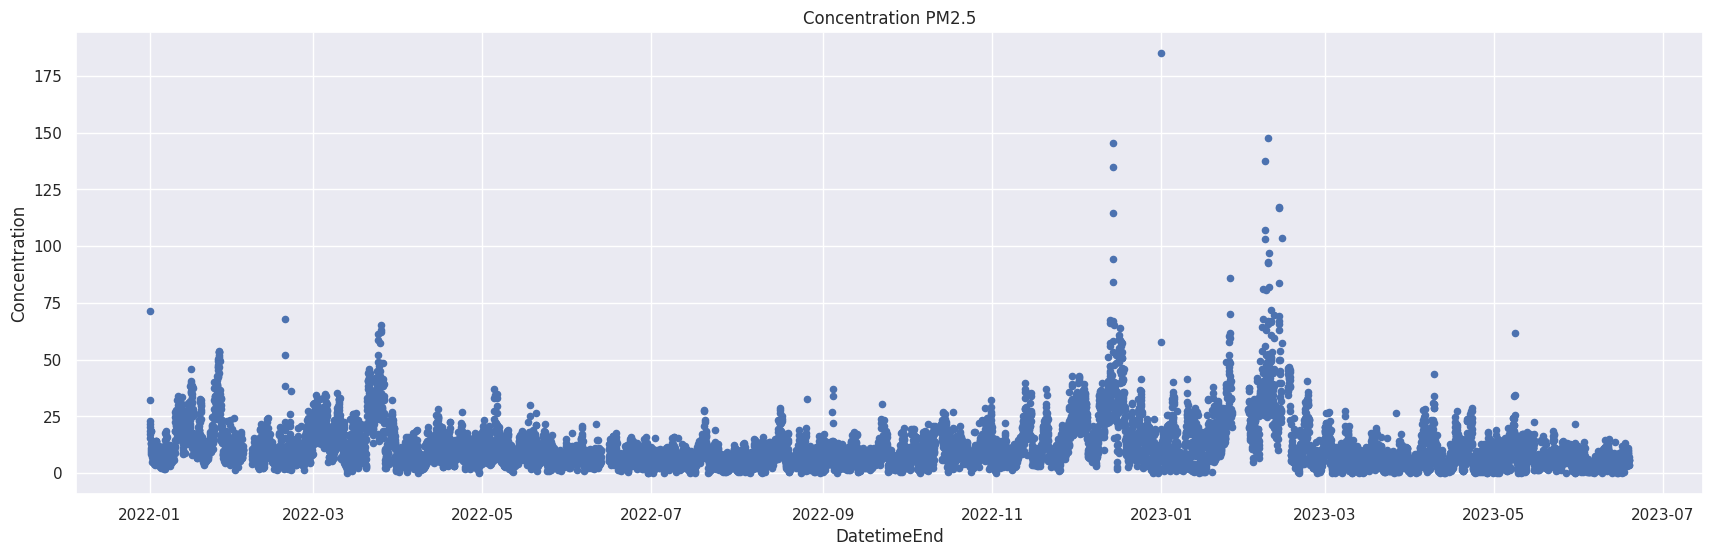

In [34]:
df_conc_prev = pd.read_csv(CSV_CONC_PREV_FILE, parse_dates=True, index_col='DatetimeEnd')
df_conc_cur = pd.read_csv(CSV_CONC_CUR_FILE, parse_dates=True, index_col='DatetimeEnd')

df_conc = pd.concat([df_conc_prev, df_conc_cur])
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
# df_conc['Concentration']['2021-01-01':'2022-02-12'].plot(ax=ax, title="AQI по загрязнителям")
df_conc['2022-01-01':].reset_index().plot(ax=ax, title="Concentration PM2.5", x='DatetimeEnd', y='Concentration', kind='scatter')

<Axes: title={'center': 'AQI PM 2.5'}, xlabel='DatetimeEnd', ylabel='AQI'>

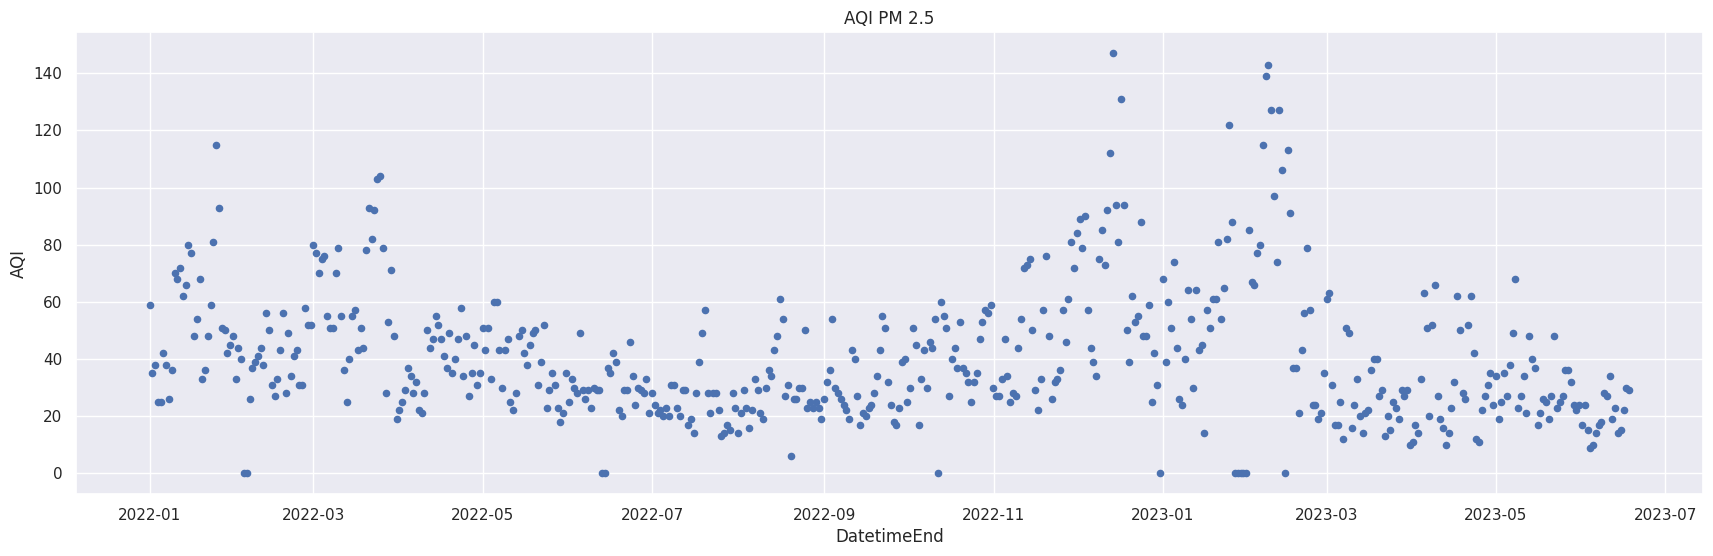

In [35]:
import data_preprocessing.aqi_calculations.aqi_calculator as aqc
poll_id = 6001
POL_MEASURES = {7: "µg/m3", 6001: "µg/m3", 5: "µg/m3", 10: "mg/m3", 1: "µg/m3", 8: "µg/m3"}
measure = POL_MEASURES[poll_id]
g = aqc.calc_aqi_for_day_pd(poll_id, df_conc, measure)
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
#df_joint['AQI_PM25']['2022-01-01':'2023-02-12'].plot(ax=ax, title="AQI по загрязнителям", kind='scatter')
g['2022-01-01':].reset_index().plot(ax=ax, title="AQI PM 2.5", x='DatetimeEnd', y='AQI', kind='scatter')

In [36]:
import data_preprocessing.features_generations.ts_date_features_generator as date_gen
import data_preprocessing.features_generations.ts_lag_features_generator as lag_gen
FORECAST_DURATION_DAYS = 7
TS_DATE_FROM = '2015-01-01'
TS_DATE_END = '2023-02-12'

df_g = date_gen.add_date_info(g)
df_g.drop(columns=['is_weekend', 'season', 'is_new_year'], inplace=True)
display(df_g.head())

AQI  weekday  day  month  year
DatetimeEnd                                              
2015-01-01 00:00:00+01:00  128        3    1      1  2015
2015-01-02 00:00:00+01:00   46        4    2      1  2015
2015-01-03 00:00:00+01:00   46        5    3      1  2015
2015-01-04 00:00:00+01:00   32        6    4      1  2015
2015-01-05 00:00:00+01:00   80        0    5      1  2015

In [16]:
import time
def timeit(show_args):
    def timeit_func(func):
        def timeit_wrapper(*args, **kwargs):
            start_time = time.perf_counter()
            result = func(*args, **kwargs)
            end_time = time.perf_counter()
            total_time = end_time - start_time
            if show_args:
                print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
            else:
                print(f'Function {func.__name__} Took {total_time:.4f} seconds')
            return result
        return timeit_wrapper
    return timeit_func

In [17]:
@timeit(show_args=False)
def get_lag_data_shift(df: pd.DataFrame) -> pd.DataFrame:
    df_c = df.copy(deep=True)
    target_cols = ['AQI']
    lags = [7, 8, 9, 10, 11, 12,  13, 14, 21, 28]

    for column in target_cols:
        for lag in lags:
            df_c[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df_c

@timeit(show_args=False)
def get_lag_data_aqi(df: pd.DataFrame) -> pd.DataFrame:
        method_name = 'get_lag_data_aqi'
        print(f'-------------------------------------------')
        print(f'{method_name} started')

        target_cols = ['AQI']
        id_cols = []
        date_col = 'DatetimeEnd'
        filters = ['NoFilter', 'weekday', 'month']

        windows = {
            'NoFilter': ['3D', '5D', '7D', '14D', '28D'],
            'weekday':  ['28D', '56D'],
            'month':    ['90D']
        }
        lags = [7, 10, 14, 21, 28]
        agg_methods =['mean', 'median', 'percentile(10)', 'percentile(90)'] #, pd.Series.skew, pd.Series.kurtosis]
        ewm_params={
            'NoFilter': [7, 14, 21, 28],
            'weekday': [28, 56],
            'month': [90],
        }
        df['NoFilter'] = 1

        total = len(target_cols) * len(lags) * len(windows) * len(agg_methods) * len(filters)
        print(f'New columns count: {total}')

        df_lagged_features = lag_gen.generate_lagged_features(df
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = lags
                    , windows = windows
                    , preagg_methods = ['mean']
                    , agg_methods = agg_methods
                    , dynamic_filters = filters
                    , ewm_params=ewm_params
                    )
        df_lagged_features.set_index(date_col, inplace = True)

        print(f'{method_name} finished')
        return df_lagged_features

In [18]:
g_shift = get_lag_data_shift(df_g)
g_shift = get_lag_data_aqi(g_shift)
g_shift

Function get_lag_data_shift Took 0.0033 seconds
-------------------------------------------
get_lag_data_aqi started
New columns count: 180
get_lag_data_aqi finished
Function get_lag_data_aqi Took 86.7310 seconds


AQI  weekday  day  month  year  AQI_lag7  AQI_lag8  AQI_lag9   
DatetimeEnd                                                                 
2015-01-01   128        3    1      1  2015       NaN       NaN       NaN  \
2015-01-02    46        4    2      1  2015       NaN       NaN       NaN   
2015-01-03    46        5    3      1  2015       NaN       NaN       NaN   
2015-01-04    32        6    4      1  2015       NaN       NaN       NaN   
2015-01-05    80        0    5      1  2015       NaN       NaN       NaN   
...          ...      ...  ...    ...   ...       ...       ...       ...   
2023-06-12    19        0   12      6  2023      10.0       9.0      15.0   
2023-06-13    23        1   13      6  2023      14.0      10.0       9.0   
2023-06-14    14        2   14      6  2023      17.0      14.0      10.0   
2023-06-15    15        3   15      6  2023      18.0      17.0      14.0   
2023-06-16    22        4   16      6  2023      28.0      18.0      17.0   

             AQI_lag10  AQI_lag11  ...  AQI_lag21d_ewm90_filtmonth   
DatetimeEnd                        ...                               
2015-01-01         NaN        NaN  ...                         NaN  \
2015-01-02         NaN        NaN  ...                         NaN   
2015-01-03         NaN        NaN  ...                         NaN   
2015-01-04         NaN        NaN  ...                         NaN   
2015-01-05         NaN        NaN  ...                         NaN   
...                ...        ...  ...                         ...   
2023-06-12        24.0       17.0  ...                   28.619525   
2023-06-13        15.0       24.0  ...                   28.619525   
2023-06-14         9.0       15.0  ...                   28.619525   
2023-06-15        10.0        9.0  ...                   28.619525   
2023-06-16        14.0       10.0  ...                   28.619525   

             AQI_lag21d_win90D_agmean_filtmonth   
DatetimeEnd                                       
2015-01-01                                  NaN  \
2015-01-02                                  NaN   
2015-01-03                                  NaN   
2015-01-04                                  NaN   
2015-01-05                                  NaN   
...                                         ...   
2023-06-12                                  NaN   
2023-06-13                                  NaN   
2023-06-14                                  NaN   
2023-06-15                                  NaN   
2023-06-16                                  NaN   

             AQI_lag21d_win90D_agmedian_filtmonth   
DatetimeEnd                                         
2015-01-01                                    NaN  \
2015-01-02                                    NaN   
2015-01-03                                    NaN   
2015-01-04                                    NaN   
2015-01-05                                    NaN   
...                                           ...   
2023-06-12                                    NaN   
2023-06-13                                    NaN   
2023-06-14                                    NaN   
2023-06-15                                    NaN   
2023-06-16                                    NaN   

             AQI_lag21d_win90D_agpercentile(10)_filtmonth   
DatetimeEnd                                                 
2015-01-01                                            NaN  \
2015-01-02                                            NaN   
2015-01-03                                            NaN   
2015-01-04                                            NaN   
2015-01-05                                            NaN   
...                                                   ...   
2023-06-12                                            NaN   
2023-06-13                                            NaN   
2023-06-14                                            NaN   
2023-06-15                                            NaN   
2023-06-16    

<Axes: title={'center': 'AQI PM 2.5'}, xlabel='DatetimeEnd'>

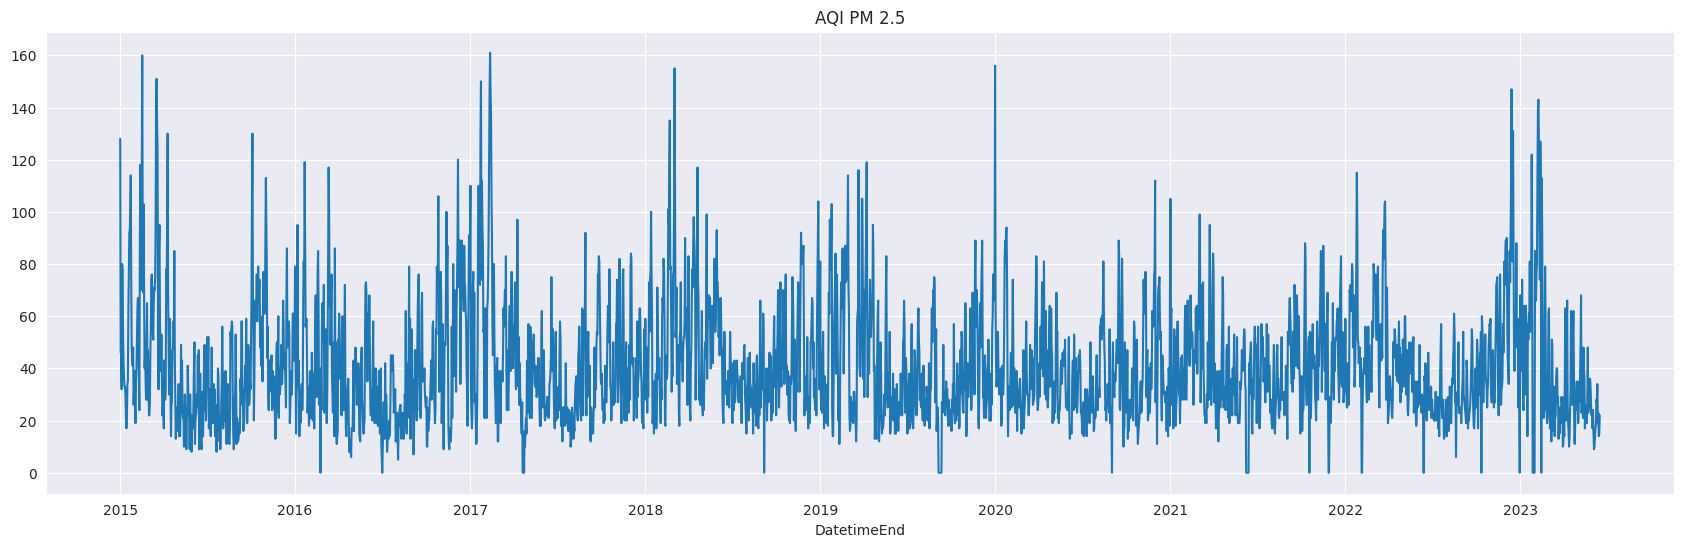

In [19]:
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
g_shift['AQI'].plot(ax=ax, title="AQI PM 2.5")

In [20]:
#g_shift.reset_index().set_index('DatetimeEnd')['2022-01-01':'2023-02-12']
g_shift_c = g_shift.copy()
g_shift_c.reset_index(inplace=True)
g_shift_c['DatetimeEnd'] = pd.DatetimeIndex(g_shift_c['DatetimeEnd'])
g_shift_c.set_index('DatetimeEnd',inplace=True, drop=True)

<Axes: title={'center': 'AQI PM 2.5'}, xlabel='DatetimeEnd', ylabel='AQI'>

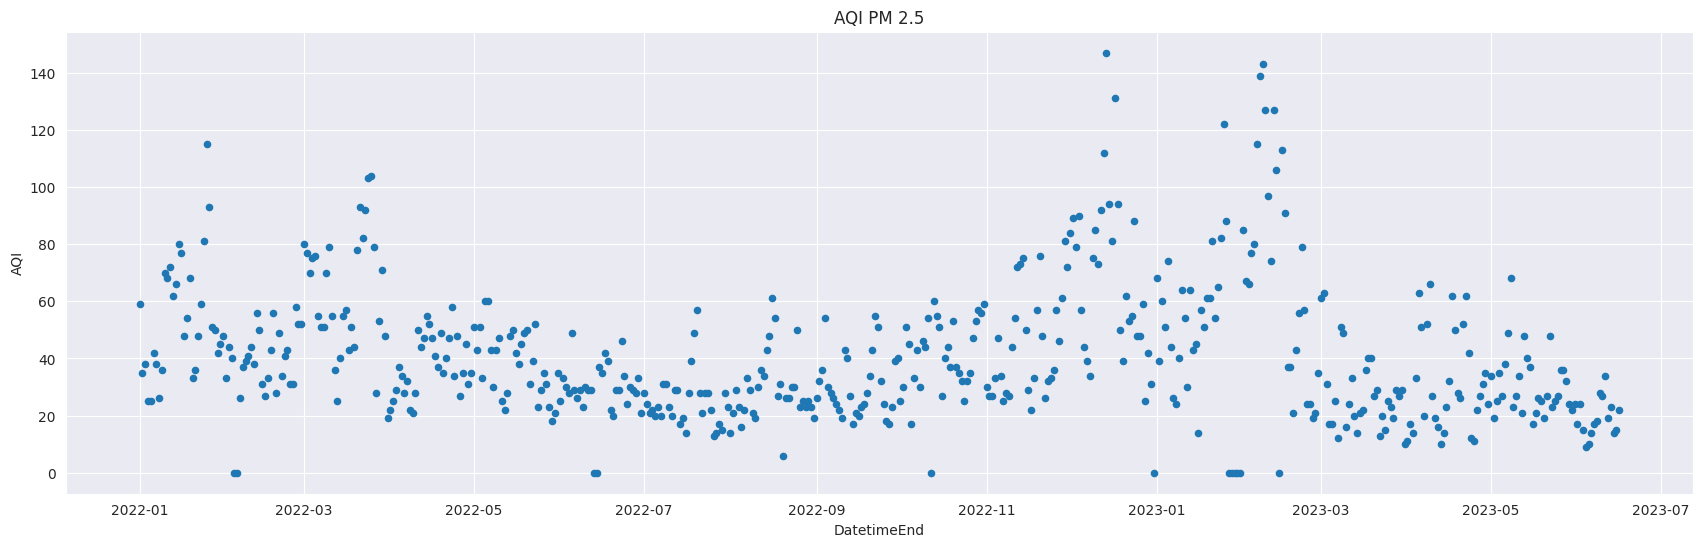

In [21]:
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
g_shift_c['2022-01-01':].reset_index().plot(ax=ax, title="AQI PM 2.5", x='DatetimeEnd', y='AQI', kind='scatter')

### Weather load

In [22]:
df_weather_prev = pd.read_csv(CSV_WEATHER_PREV_FILE, parse_dates=True, index_col='date')
df_weather_cur = pd.read_csv(CSV_WEATHER_CUR_FILE, parse_dates=True, index_col='date')
df_weather_prev_c = df_weather_prev.copy()
df_weather_cur_c = df_weather_cur.copy()
df_weather_prev_c.reset_index(inplace=True)
df_weather_cur_c.reset_index(inplace=True)
df_weather_prev_c['date'] = pd.DatetimeIndex(df_weather_prev_c['date'])
df_weather_cur_c['date'] = pd.DatetimeIndex(df_weather_cur_c['date'])
df_weather_prev_c.set_index('date',inplace=True, drop=True)
df_weather_cur_c.set_index('date',inplace=True, drop=True)
df_weather = pd.concat([df_weather_prev_c, df_weather_cur_c])

In [23]:
df_weather.head()

tavg  tmin  tmax  prcp   wdir  wspd  wpgt  pres
date                                                       
2015-01-01   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN
2015-01-02   7.4   5.0  11.0   NaN  256.0  31.3   NaN   NaN
2015-01-03   4.6   2.9   6.2   NaN    NaN  15.0   NaN   NaN
2015-01-04   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN
2015-01-05   3.1   1.0   4.2   NaN  196.0  13.8   NaN   NaN

In [24]:
df_joint = g_shift_c.merge(df_weather, how='left', left_index=True, right_index=True)
df_joint.rename(columns={"AQI": "AQI_PM25"}, errors="raise", inplace=True)

<Axes: title={'center': 'AQI PM 2.5'}, xlabel='DatetimeEnd', ylabel='AQI_PM25'>

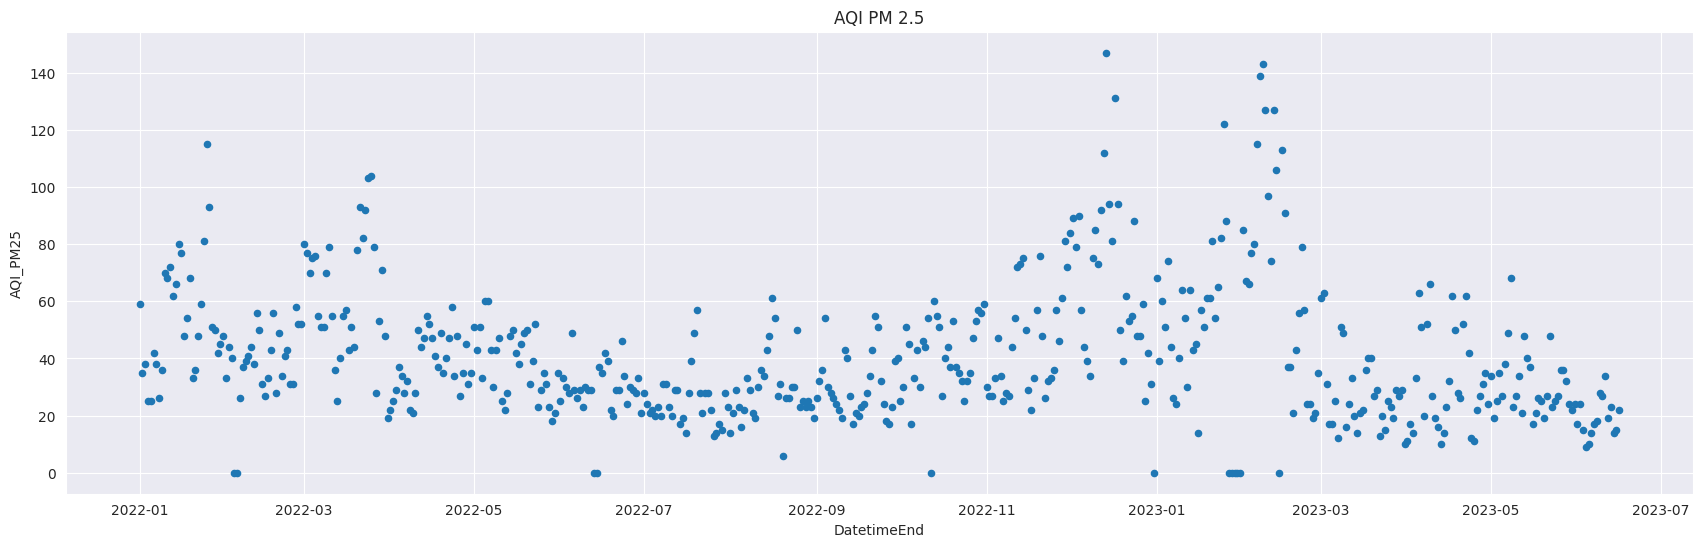

In [26]:
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
df_joint['2022-01-01':].reset_index().plot(ax=ax, title="AQI PM 2.5", x='DatetimeEnd', y='AQI_PM25', kind='scatter')

In [27]:
df_joint.to_csv(CSV_JOINT_FILE)

### Load saved data

In [9]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')
# df_joint = df_joint[df_joint['Pollutant'] == 6001]

<Axes: title={'center': 'AQI PM 2.5 - file'}, xlabel='DatetimeEnd', ylabel='AQI_PM25'>

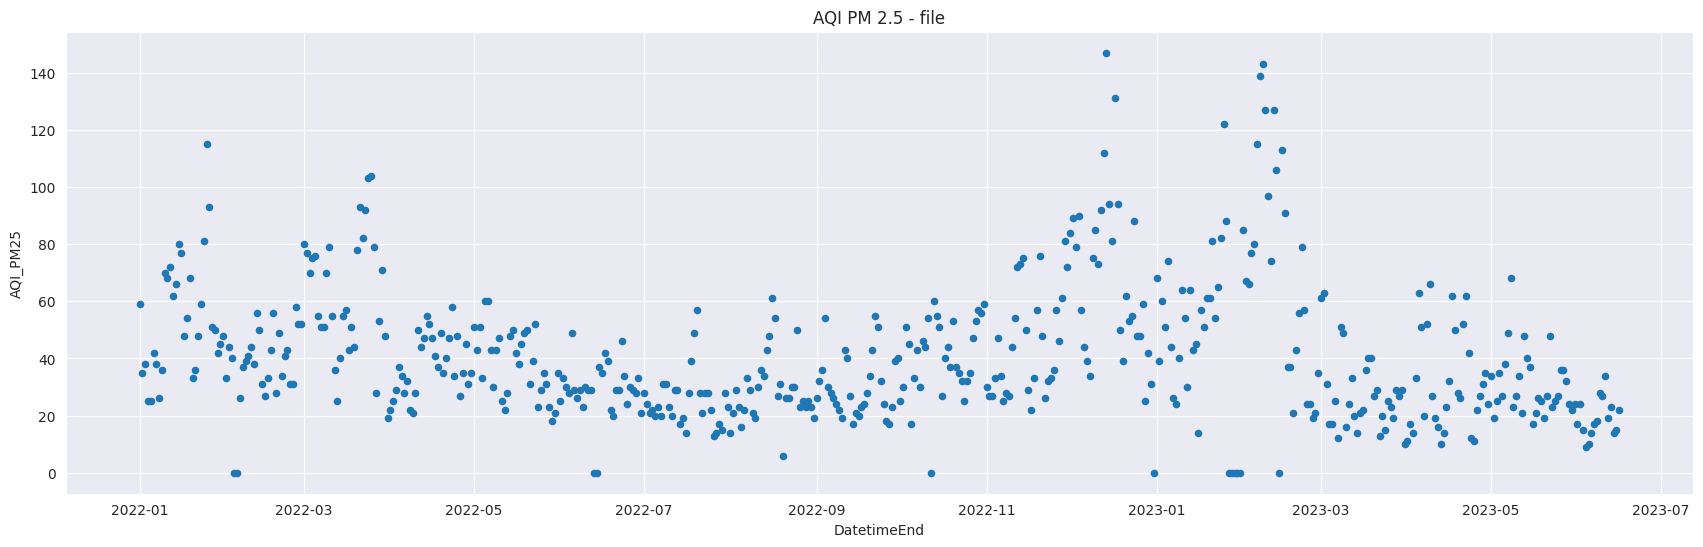

In [10]:
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
#df_joint['AQI_PM25']['2022-01-01':'2023-02-12'].plot(ax=ax, title="AQI по загрязнителям", kind='scatter')
df_joint['2022-01-01':].reset_index().plot(ax=ax, title="AQI PM 2.5 - file", x='DatetimeEnd', y='AQI_PM25', kind='scatter')

In [6]:
display(df_joint.head())

AQI_PM25  weekday  day  month  year  AQI_lag7  AQI_lag8   
DatetimeEnd                                                            
2015-01-01        128        3    1      1  2015       NaN       NaN  \
2015-01-02         46        4    2      1  2015       NaN       NaN   
2015-01-03         46        5    3      1  2015       NaN       NaN   
2015-01-04         32        6    4      1  2015       NaN       NaN   
2015-01-05         80        0    5      1  2015       NaN       NaN   

             AQI_lag9  AQI_lag10  AQI_lag11  ...   
DatetimeEnd                                  ...   
2015-01-01        NaN        NaN        NaN  ...  \
2015-01-02        NaN        NaN        NaN  ...   
2015-01-03        NaN        NaN        NaN  ...   
2015-01-04        NaN        NaN        NaN  ...   
2015-01-05        NaN        NaN        NaN  ...   

             AQI_lag28d_win90D_agpercentile(10)_filtmonth   
DatetimeEnd                                                 
2015-01-01                                            NaN  \
2015-01-02                                            NaN   
2015-01-03                                            NaN   
2015-01-04                                            NaN   
2015-01-05                                            NaN   

             AQI_lag28d_win90D_agpercentile(90)_filtmonth  tavg  tmin  tmax   
DatetimeEnd                                                                   
2015-01-01                                            NaN   NaN   NaN   NaN  \
2015-01-02                                            NaN   7.4   5.0  11.0   
2015-01-03                                            NaN   4.6   2.9   6.2   
2015-01-04                                            NaN   NaN   NaN   NaN   
2015-01-05                                            NaN   3.1   1.0   4.2   

             prcp   wdir  wspd  wpgt  pres  
DatetimeEnd                                 
2015-01-01    NaN    NaN   NaN   NaN   NaN  
2015-01-02    NaN  256.0  31.3   NaN   NaN  
2015-01-03    NaN    NaN  15.0   NaN   NaN  
2015-01-04    NaN    NaN   NaN   NaN   NaN  
2015-01-05    NaN  196.0  13.8   NaN   NaN  

[5 rows x 219 columns]

In [4]:
df_score = pd.DataFrame(columns=['train_score', 'val_score', 'target', 'pol_id', 'weather_YN', 'AQI_lags_YN', 'C_lags_YN', 'simple_lags_YN', 'gen_lags_YN', 'params', 'categories', 'top_feat_count'])

## Functions

In [19]:
def score_by_feature_count(o_helper, len_features, params, categories):
    tr_by_cat = []
    vl_by_cat = []
    o_helper.study_best_params = params
    for cat in categories:
        train_scs = []
        val_scs = []
        for i in range(1, len_features):
            o_helper.set_best_features_by_count(i)
            score_tr, score_vl, mdl = o_helper.run_model_and_eval(params=params,  categorical_features=cat, best_features_only=True, set_as_best_model=False)
            train_scs.append(score_tr)
            val_scs.append(score_vl)
        tr_by_cat.append(train_scs)
        vl_by_cat.append(val_scs)
    return tr_by_cat, vl_by_cat


def plot_score_grouped_by_categories_by_feature_count(len_features, score_by_cat, sub_title=""):
    plt.figure(figsize=(21, 7))
    for i in range(0, len(categories)):
        plt.plot(range(1, len_features),score_by_cat[i], label=("_".join(categories[i]) if len(categories[i]) > 0 else "no_cat"))
    plt.title(f'Score by features count. {sub_title}')
    plt.legend()
    plt.show()


def plot_train_val_score_by_feature_count(len_features, train_scs, val_scs, sub_title=""):
    plt.figure(figsize=(21, 7))
    plt.plot(range(1, len_features),train_scs, label="train_score")
    plt.plot(range(1, len_features),val_scs, label="val_score")
    plt.title(f'Train/Val score by features count. {sub_title}')
    plt.legend()
    plt.show()


def score_and_plot_by_feature_count(o_helper, len_features, params, categories):
    tr_by_cat, vl_by_cat = score_by_feature_count(o_helper, len_features, params, categories)
    plot_score_grouped_by_categories_by_feature_count(len_features, tr_by_cat, sub_title="Train scores")
    plot_score_grouped_by_categories_by_feature_count(len_features, vl_by_cat, sub_title="Val scores")
    for i in range(len(categories)):
        plot_train_val_score_by_feature_count(len_features, tr_by_cat[i], vl_by_cat[i],
                                              sub_title=f"First cats: {('_'.join(categories[i]) if len(categories[i]) > 0 else 'no_cat')}")


def init_optuna_helper(df, pol_id, default_category, categories, use_aqi_cols=False, use_c_mean_cols=True, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True, df_filtered=False):
    default_params = {'n_jobs': -1, 'verbosity': -1, 'metric': METRIC, 'boosting_type': 'gbdt',
    'extra_trees': True, 'n_estimators': 1000, 'num_leaves': 150, 'learning_rate': 0.01, 'subsample': 0.7, 'subsample_freq': 5, 'subsample_for_bin': 100000, 'min_child_samples': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'max_depth': 10, 'max_bin': 150}
    o_helper, x_tr, y_tr, x_vl, y_vl = tuner.init_optuna(
        df_timeseries=df, pol_id=pol_id, prediction_value_type="AQI",
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO, default_params=default_params, default_category=default_category, categories_for_optimization=categories, default_top_features_count=-1, df_filtered=df_filtered)
    return o_helper, x_tr, y_tr, x_vl, y_vl


def run_test(df, pol_id, default_category, categories, use_aqi_cols=False, use_c_mean_cols=True, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True, best_features_only=True, search_category=True, n_trials=100, n_jobs=6, df_filtered=False):

    o_helper, x_tr, y_tr, x_vl, y_vl = init_optuna_helper(df, pol_id, default_category, categories, use_aqi_cols, use_c_mean_cols, use_lag_cols,use_gen_lags_cols, use_weather_cols, df_filtered=df_filtered)

    o_helper.run_params_search(n_trials=n_trials, n_jobs=n_jobs, study_name="_", save_best_params=True,   direction=OPTIMIZATION_DIRECTION, best_features_only=best_features_only, search_category=search_category, with_pruner=True, cv_splitter= TimeSeriesSplit(16), warm_params=None)

    best_params = o_helper.study_best_params
    best_categories = o_helper.study_best_params['categorical_features'] if search_category else default_category
    best_features_count = len(x_tr.columns)

    score_train, score_val, _ = o_helper.run_model_and_eval(params=best_params,  categorical_features=best_categories, best_features_only=True, set_as_best_model=True)

    feat_imp_df = feat_imp_ext.get_and_plot_feature_importance(o_helper.best_model, o_helper.best_features_list, num=30, plot_bar=True)
    return o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df


def run_model_by_feature_count(o_helper, best_params, best_categories, best_features_count):
    o_helper.study_best_params = best_params
    o_helper.set_best_features_by_count(best_features_count)
    score_tr, score_vl, _ = o_helper.run_model_and_eval(params=best_params,  categorical_features=best_categories, best_features_only=True, set_as_best_model=True)
    return score_tr, score_vl


def save_score_and_params(target, pol_id, use_weather_cols, use_aqi_cols, use_c_mean_cols, use_lag_cols, use_gen_lags_cols,
                          best_params, best_categories, best_features_count, score_train, score_val):
    df_score.loc[df_score.shape[0]] = {'target': target, 'pol_id' : pol_id, 'weather_YN': use_weather_cols, 'AQI_lags_YN': use_aqi_cols,
                                       'C_lags_YN': use_c_mean_cols, 'simple_lags_YN': use_lag_cols, 'gen_lags_YN': use_gen_lags_cols,
                                       'params': best_params, 'categories': best_categories, 'top_feat_count': best_features_count,
                                       'train_score': score_train, 'val_score': score_val }
    df_score.to_csv(CSV_SCORE_FILE)

def get_prediction(df, pol_id, use_weather_cols, use_aqi_cols, use_c_mean_cols, use_lag_cols, use_gen_lags_cols, best_params, best_categories, best_feat_count):
    o_helper, _, _, x_vl, y_vl = tuner.init_optuna(
        df_timeseries=df, pol_id=pol_id, prediction_value_type="AQI",
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
        use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO,
        default_params=best_params, default_category=best_categories, default_top_features_count=best_feat_count, df_filtered=True)

    score_train, score_val, _ = o_helper.run_model_and_eval(best_features_only=True, set_as_best_model=True)
    y_vl_pred = [int(round(x, 0)) for x in o_helper.predict_by_best_model(x_vl)]
    return score_train, score_val, y_vl_pred, x_vl, y_vl, o_helper

# Test models

## PM 2.5

### PM2.5 - AQI weather, lags, gen lags

In [237]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =True
use_weather_cols = True

In [7]:
# lgb_train = lgb.Dataset(data=x_train, label=y_train,
#                         categorical_feature=categorical_features)
# lgb_eval = lgb.Dataset(data=x_val, label=y_val,
#                        categorical_feature=categorical_features,
#                        reference=lgb_train)
# evals_result = {}
# callbacks = [early_stopping(100, verbose=False), log_evaluation(0)]
#
# if pruning_callback is not None:
#     callbacks.append(pruning_callback)
#
# model = lgb.train(params, lgb_train,
#                   num_boost_round=50,
#                   categorical_feature=categorical_features,
#                   # valid_sets=[lgb_train, lgb_eval],
#                   # valid_names=["train", "val"],
#                   verbose_eval=False,
#                   # evals_result=evals_result,
#                   # callbacks=callbacks
#                   )
#
# train_score = evals_result['train'][self.metric][-1]
# val_score = evals_result['val'][self.metric][-1]
# if set_as_best_model:
#     self.__save_best_model(model, categorical_features, train_score, val_score)
# return train_score, val_score, model

In [9]:
default_params = {'n_jobs': -1, 'verbosity': -1, 'metric': 'rmse', 'boosting_type': 'gbdt',
'extra_trees': True, 'n_estimators': 1000, 'num_leaves': 150, 'learning_rate': 0.01, 'subsample': 0.7, 'subsample_freq': 5, 'subsample_for_bin': 100000, 'min_child_samples': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'max_depth': 10, 'max_bin': 150}

o_helper, x_tr, y_tr, x_vl, y_vl = tuner.init_optuna(
    df_timeseries=df_joint, pol_id=pol_id, prediction_value_type="AQI",
    use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
    train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO, default_params=default_params, default_category=default_category, categories_for_optimization=categories, default_top_features_count=-1)

In [ ]:
{'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 3000, 'num_leaves': 57, 'learning_rate': 0.05506549255255998, 'subsample': 0.1743215556252623, 'subsample_freq': 5, 'subsample_for_bin': 295339, 'min_child_samples': 284, 'reg_alpha': 0.6873083223630964, 'reg_lambda': 0.5414791465350673, 'max_depth': 11, 'max_bin': 229, 'categorical_features': ['season', 'month', 'weekday']}

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 47.65738808816404 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2600, 'num_leaves': 43, 'learning_rate': 0.057825301370103506, 'subsample': 0.1233713240097077, 'subsample_freq': 6, 'subsample_for_bin': 423104, 'min_child_samples': 204, 'reg_alpha': 0.6771331949462018, 'reg_lambda': 0.1514133559938574, 'max_depth': 4, 'max_bin': 223, 'categorical_features': ['season', 'month', 'weekday']}. 
Trial 4 finished with best value: 34.6169052534787 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1700, 'num_leaves': 49, 'learning_rate': 0.11650310063766489, 'subsample': 0.3955142463108443, 'subsample_freq': 10, 'subsample_for_bin': 482423, 'min_child_samples': 364, 'reg_alpha': 0.7674189659582914, 'reg_lambda': 0.1697367666813675, 'max_depth': 9, 'm

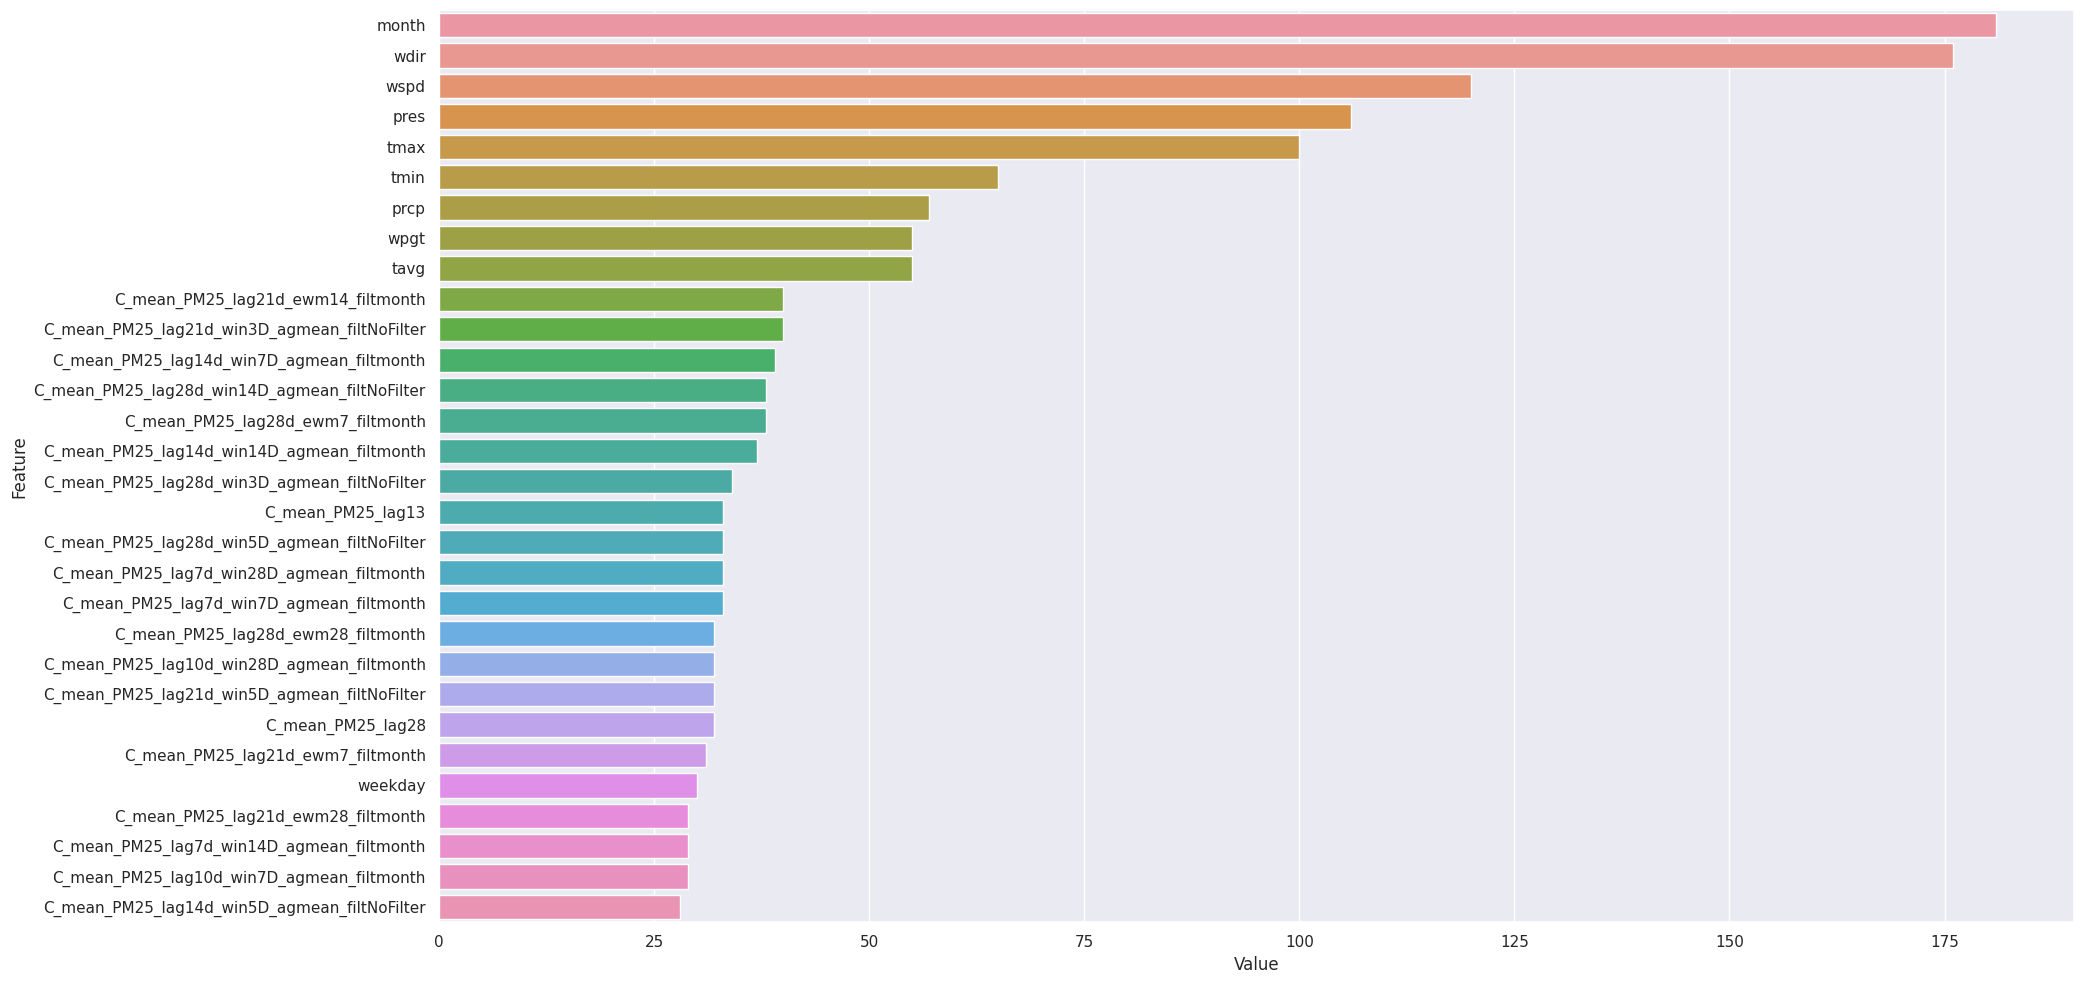

(8.330141813585344, 39.172289961058844)

In [9]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [17]:
dddf = optuna_tuner.study.trials_dataframe()
#dddf[[dddf['state'] == 'FAIL']]
dddf[dddf['state'] == 'FAIL']

Empty DataFrame
Columns: [number, value, datetime_start, datetime_complete, duration, params_boosting_type, params_categorical_features, params_extra_trees, params_learning_rate, params_max_bin, params_max_depth, params_metric, params_min_child_samples, params_n_estimators, params_n_jobs, params_num_leaves, params_objective, params_reg_alpha, params_reg_lambda, params_subsample, params_subsample_for_bin, params_subsample_freq, params_verbosity, state]
Index: []

[0 rows x 24 columns]

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}

score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), params=best_params, categories=categories)

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_categories = ['month', 'weekday']
best_features_count = 70

optuna_tuner, _, _, _, _ = init_optuna_helper(df_joint, pol_id, default_category=best_categories, categories=[],
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
                                          use_weather_cols=use_weather_cols)

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI lags, gen lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =True
use_weather_cols = False

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2900, 'num_leaves': 66, 'learning_rate': 0.12773019092749138, 'subsample': 0.7831659496800467, 'subsample_freq': 8, 'subsample_for_bin': 391616, 'min_child_samples': 73, 'reg_alpha': 0.6968311953663399, 'reg_lambda': 0.32426383763516786, 'max_depth': 5, 'max_bin': 329}
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI weather, lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =False
use_weather_cols = True

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [ ]:
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI weather, gen lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = False
use_gen_lags_cols =True
use_weather_cols = True

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
# best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1600, 'num_leaves': 145, 'learning_rate': 0.09686633344736045, 'subsample': 0.9783886230574863, 'subsample_freq': 3, 'subsample_for_bin': 210165, 'min_child_samples': 36, 'reg_alpha': 0.6996611491876404, 'reg_lambda': 0.6668213755991776, 'max_depth': 5, 'max_bin': 339}

score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), params=best_params, categories=categories)

In [ ]:
best_categories = ['season', 'month']
best_features_count = 73

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_categories = ['month', 'weekday']
best_features_count = 73

optuna_tuner, _, _, _, _ = init_optuna_helper(df_joint, pol_id, default_category=best_categories, categories=[],
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
                                          use_weather_cols=use_weather_cols)

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), params=best_params, categories=categories)

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI gen lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = False
use_gen_lags_cols =True
use_weather_cols = False

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [ ]:
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols = False
use_weather_cols = False

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [ ]:
best_categories = ['season', 'month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

# Forecasts comparison

In [ ]:
df_score = pd.read_csv(CSV_SCORE_FILE)
df_score.sort_values(by='val_score', inplace=True)
display(df_score)

In [ ]:
_, y_val = ts_splitter.split_x_y_for_period(df_timeseries=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=VAL_DATE_FROM, dt_end=VAL_DATE_TO)

In [ ]:
plt.figure(figsize=(15, 4))
plt.title(f"Прогноз AQI на последние 7 дней")
plt.plot(y_val, label="actual")

for index, row in df_score.iterrows():
    str_type = ''
    if row['weather_YN']:
            str_type = 'Weather'
    if row['simple_lags_YN']:
        if str_type != '':
            str_type = str_type + '_'
        str_type = str_type + 'SimpleLags'
    if row['gen_lags_YN']:
        if str_type != '':
            str_type = str_type + '_'
        str_type = str_type + 'GenLags'

    best_pm25_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
    best_pm25_categories = ['month', 'weekday']
    best_pm25_features_count = 70

    score_train, score_val, y_pred = get_prediction(df_joint, row['pol_id'], row['weather_YN'], row['AQI_lags_YN'], row['C_lags_YN'], row['simple_lags_YN'], row['gen_lags_YN'], eval(row['params']), eval(row['categories']), row['top_feat_count'])
    print(f'{str_type}: train score: {score_train}, val score: {score_val}')
    plt.plot(y_val.index, y_pred, label=str_type + ". RMSE=%.2f" % score_val)


plt.legend()
plt.grid(True)
plt.show()

# PM2.5 - AQI + shap

Text(0.5, 1.0, 'AQI / Date ')

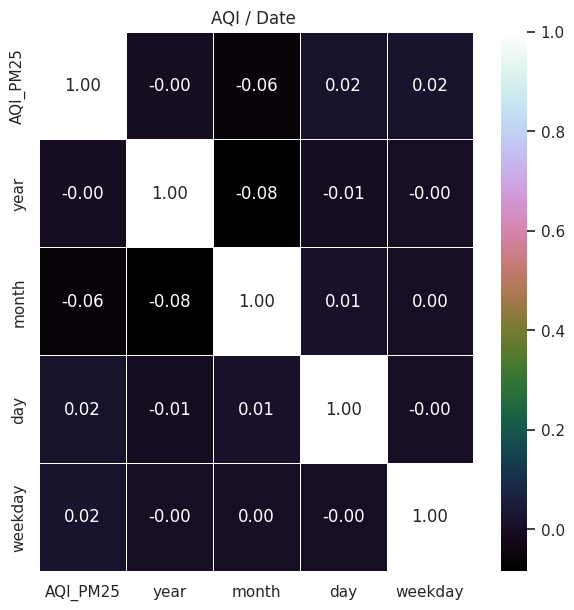

In [51]:
columns_t = ['AQI_PM25', 'year', 'month', 'day', 'weekday']
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df_joint[columns_t].corr(method='spearman'), annot=True, fmt=".2f", cmap='cubehelix', linewidths=.5, ax=ax)
ax.set_title('AQI / Date ')

Text(0.5, 1.0, 'AQI / Weather Pearson and spearman coefficients')

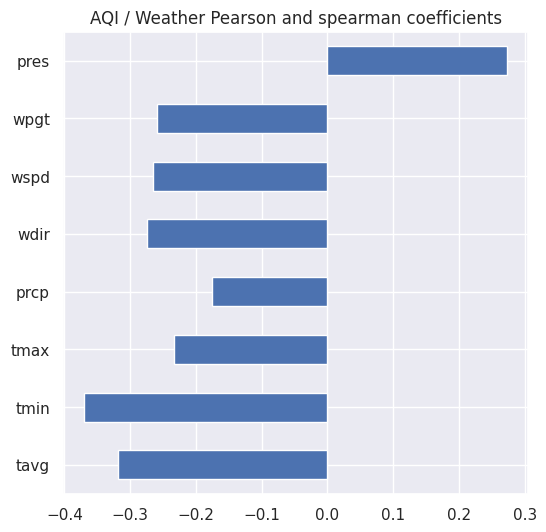

In [293]:
fig, ax = plt.subplots(figsize=(6,6))
df_joint[settings.WEATHER_COLUMNS].corrwith(df_joint['AQI_PM25'], method='pearson').plot(kind='barh', ax=ax)
ax.set_title('AQI / Weather Pearson and spearman coefficients')

Text(0.5, 1.0, 'AQI / Weather Spearman coefficients')

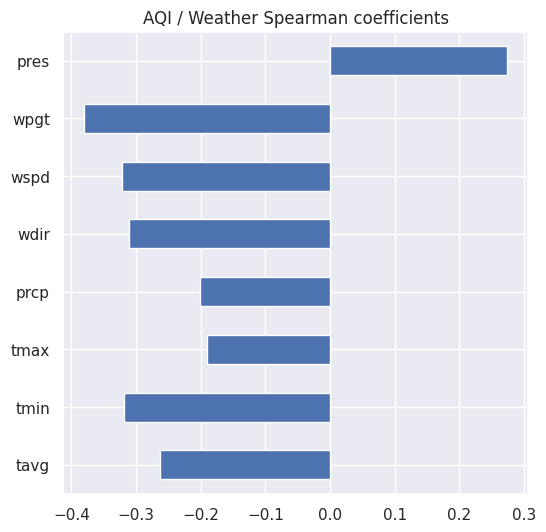

In [294]:
fig, ax = plt.subplots(figsize=(6,6))
df_joint[settings.WEATHER_COLUMNS].corrwith(df_joint['AQI_PM25'], method='spearman').plot(kind='barh', ax=ax)
ax.set_title('AQI / Weather Spearman coefficients')

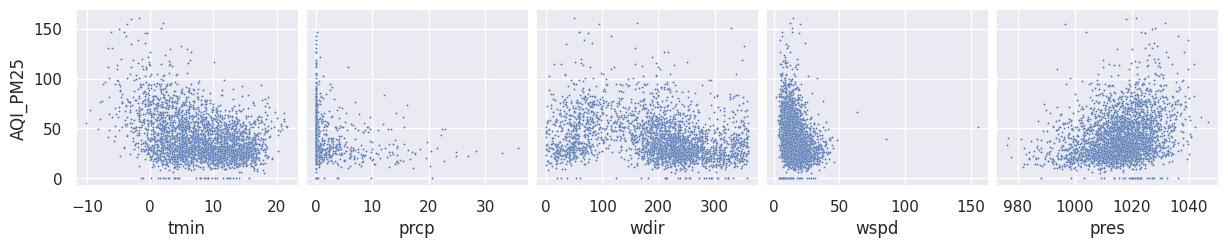

In [295]:
sns.pairplot(df_joint, y_vars=['AQI_PM25'], x_vars=['tmin', 'prcp', 'wdir', 'wspd', 'pres'], diag_kind='auto', kind='scatter', plot_kws={"s": 2}, diag_kws={'color':'green'})

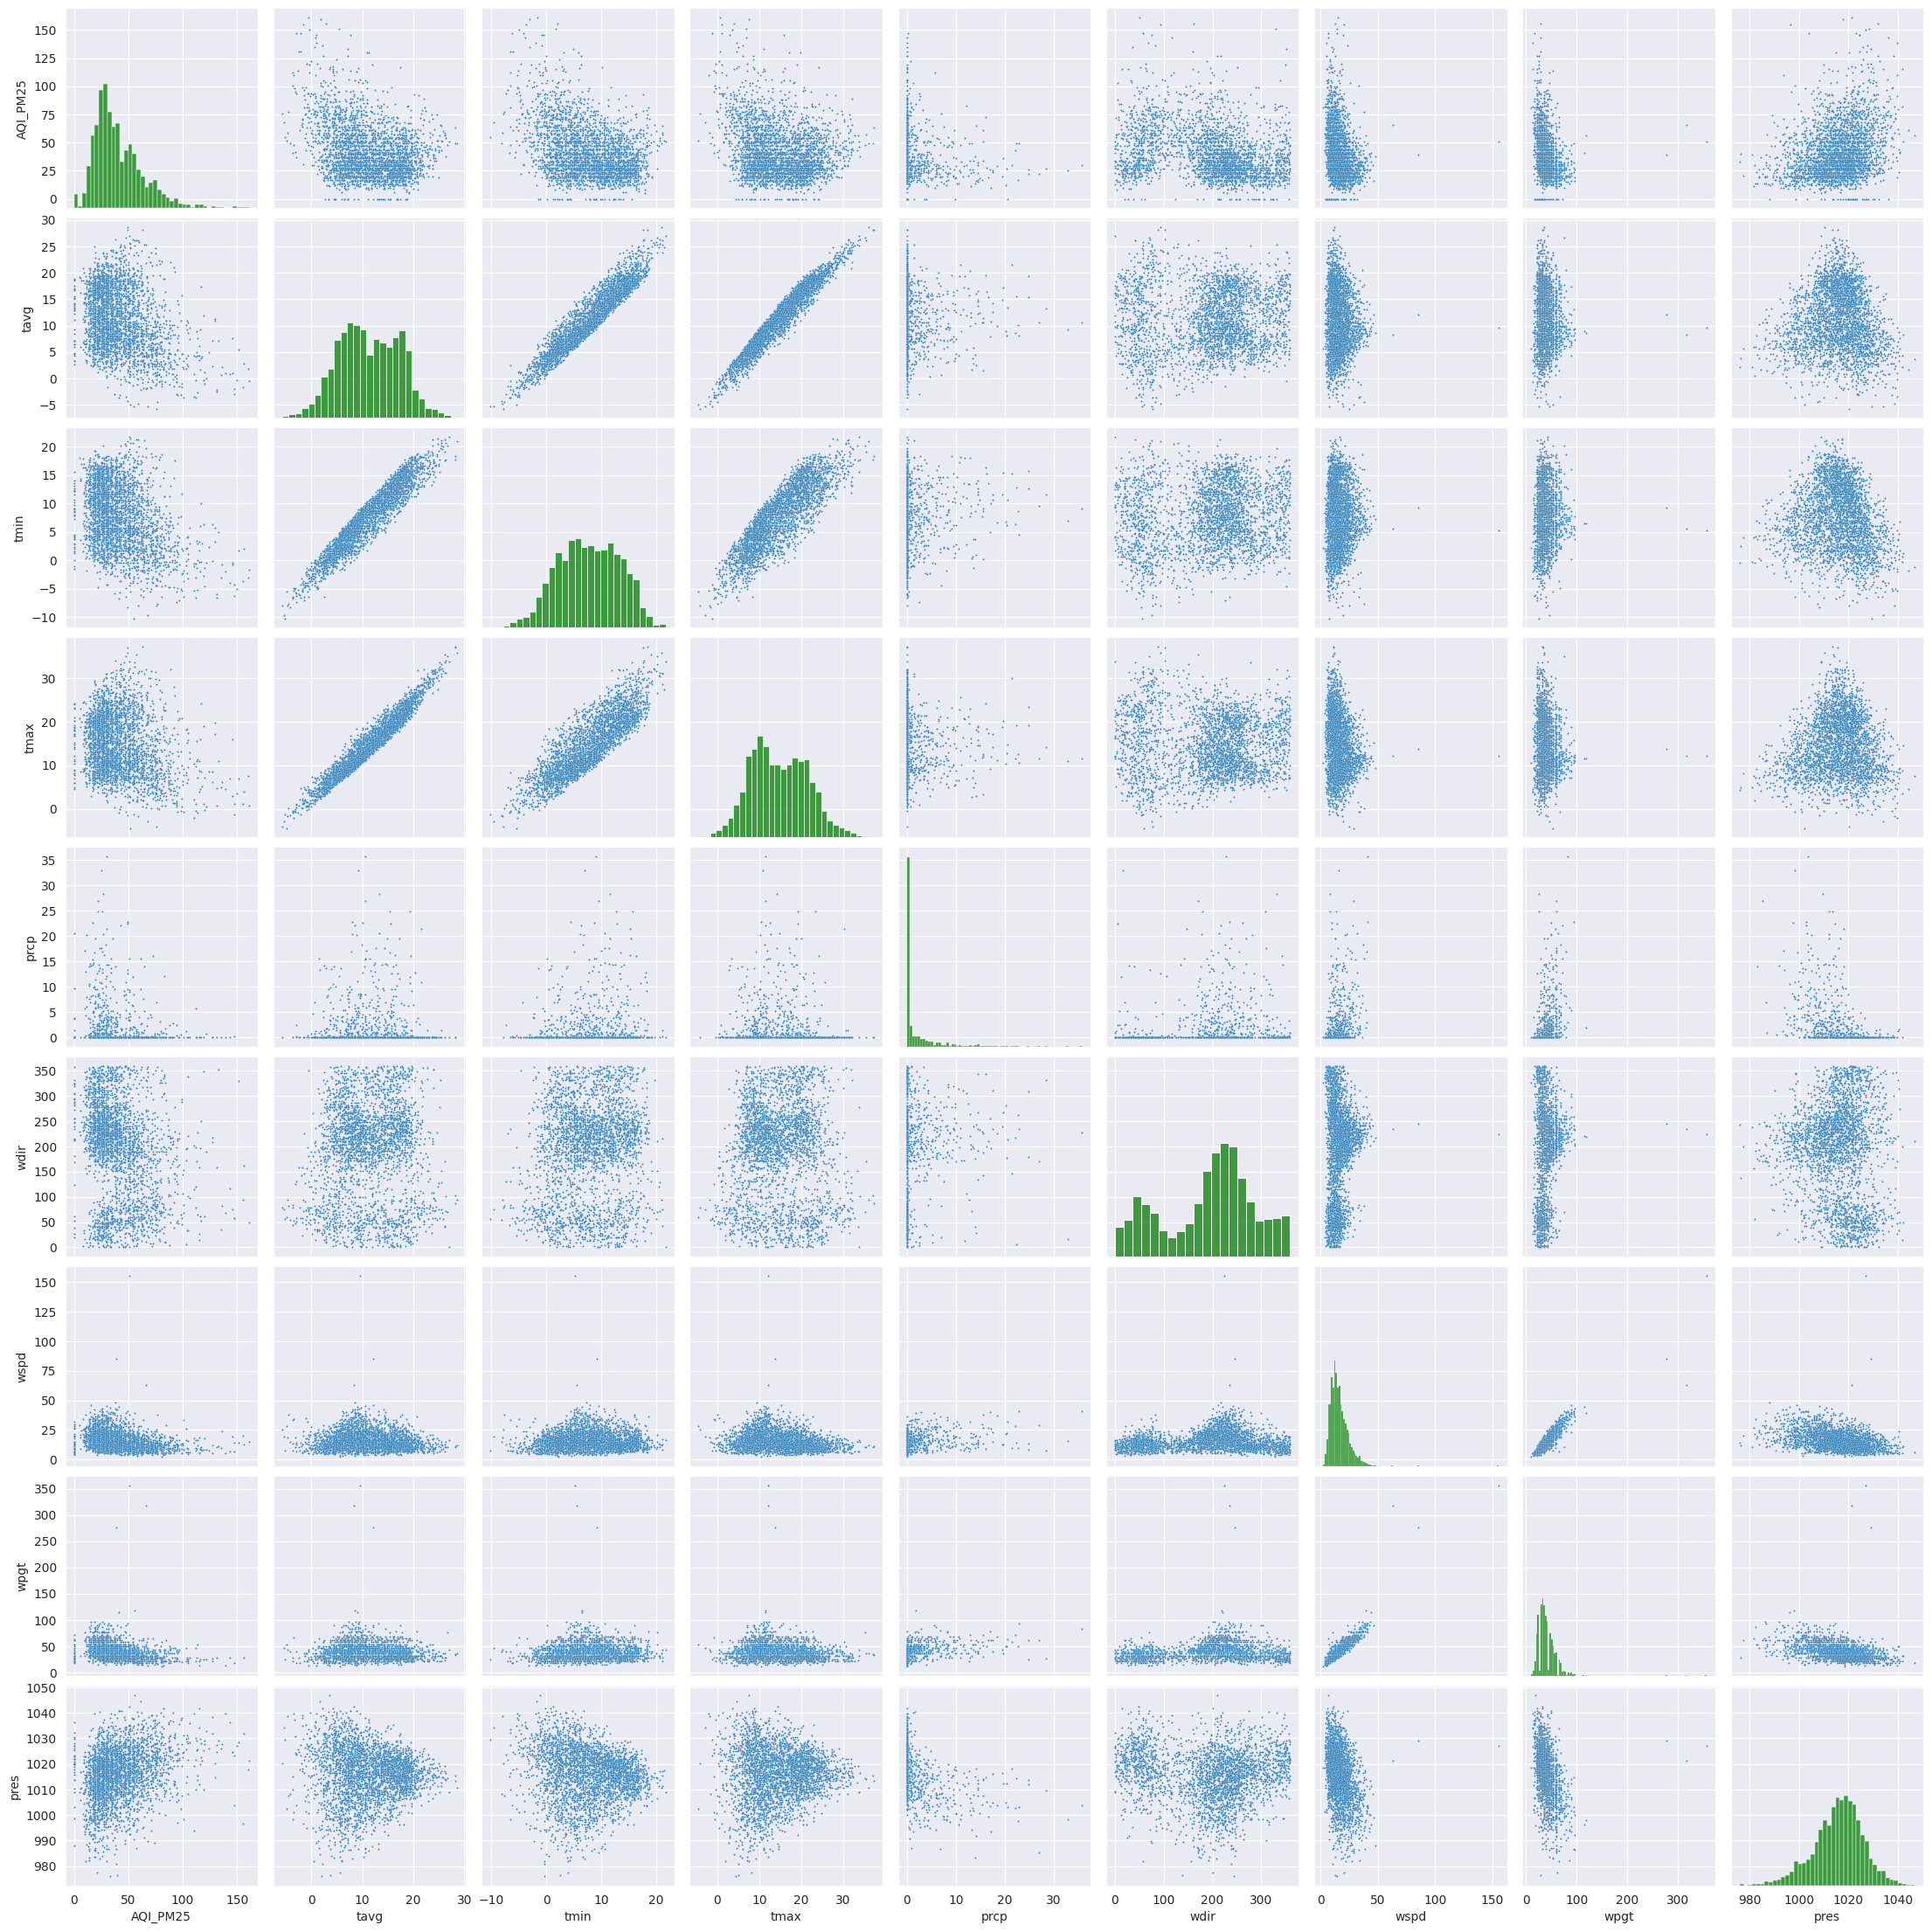

In [5]:
columns_t = ['AQI_PM25'] + settings.WEATHER_COLUMNS
sns.pairplot(df_joint[columns_t], diag_kind='auto', kind='scatter', plot_kws={"s": 2}, diag_kws={'color':'green'})

Text(0.5, 1.0, 'AQI / Weather / Date')

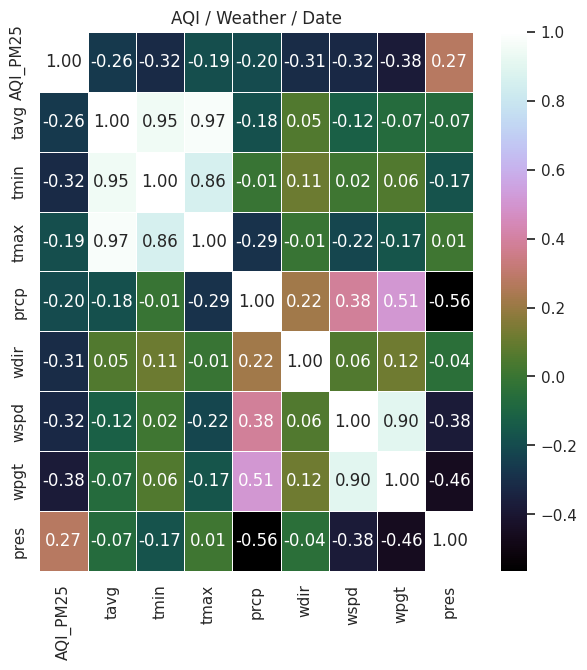

In [296]:
columns_t = ['AQI_PM25'] + settings.WEATHER_COLUMNS
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df_joint[columns_t].corr(method='spearman'), annot=True, fmt=".2f", cmap='cubehelix', linewidths=.5, ax=ax)
ax.set_title('AQI / Weather ')

In [18]:
def get_shap_feature_importance(_shap_values, _x_val):
    df_shap_values = pd.DataFrame(data=_shap_values,columns= _x_val.columns)
    df_feature_importance = pd.DataFrame(columns=['feature','importance'])
    for col in df_shap_values.columns:
        importance = df_shap_values[col].abs().mean()
        df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
    df_feature_importance = df_feature_importance.sort_values('importance',ascending=False)
    return df_feature_importance.reset_index(drop=True)

In [10]:
pol_id = 6001
categories=[['month', 'weekday']] #, ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = True

TRAIN_DATE_FROM = '2015-04-01'
TRAIN_DATE_TO = '2022-06-17'
VAL_DATE_FROM = '2022-06-18'
VAL_DATE_TO = '2023-06-17'

# VAL_DATE_FROM = '2022-05-01'
# VAL_DATE_TO = '2023-05-07'

## AQI + date

run_params_search n_trials=50, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/50 [00:00<?, ?it/s]

Trial 6 finished with best value: 43.526117655523905 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2600, 'num_leaves': 125, 'learning_rate': 0.133620790280376, 'subsample': 0.1888873504604945, 'subsample_freq': 8, 'subsample_for_bin': 171211, 'min_child_samples': 578, 'reg_alpha': 0.18962017341988857, 'reg_lambda': 0.6623279177448919, 'max_depth': 4, 'max_bin': 179}. 
Trial 1 finished with best value: 33.537404812693154 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1000, 'num_leaves': 131, 'learning_rate': 0.13390763529436725, 'subsample': 0.4043494687202872, 'subsample_freq': 9, 'subsample_for_bin': 340658, 'min_child_samples': 366, 'reg_alpha': 0.7971702729464759, 'reg_lambda': 0.2748407331946807, 'max_depth': 7, 'max_bin': 128}. 
Trial 7 finished with best value: 21.1

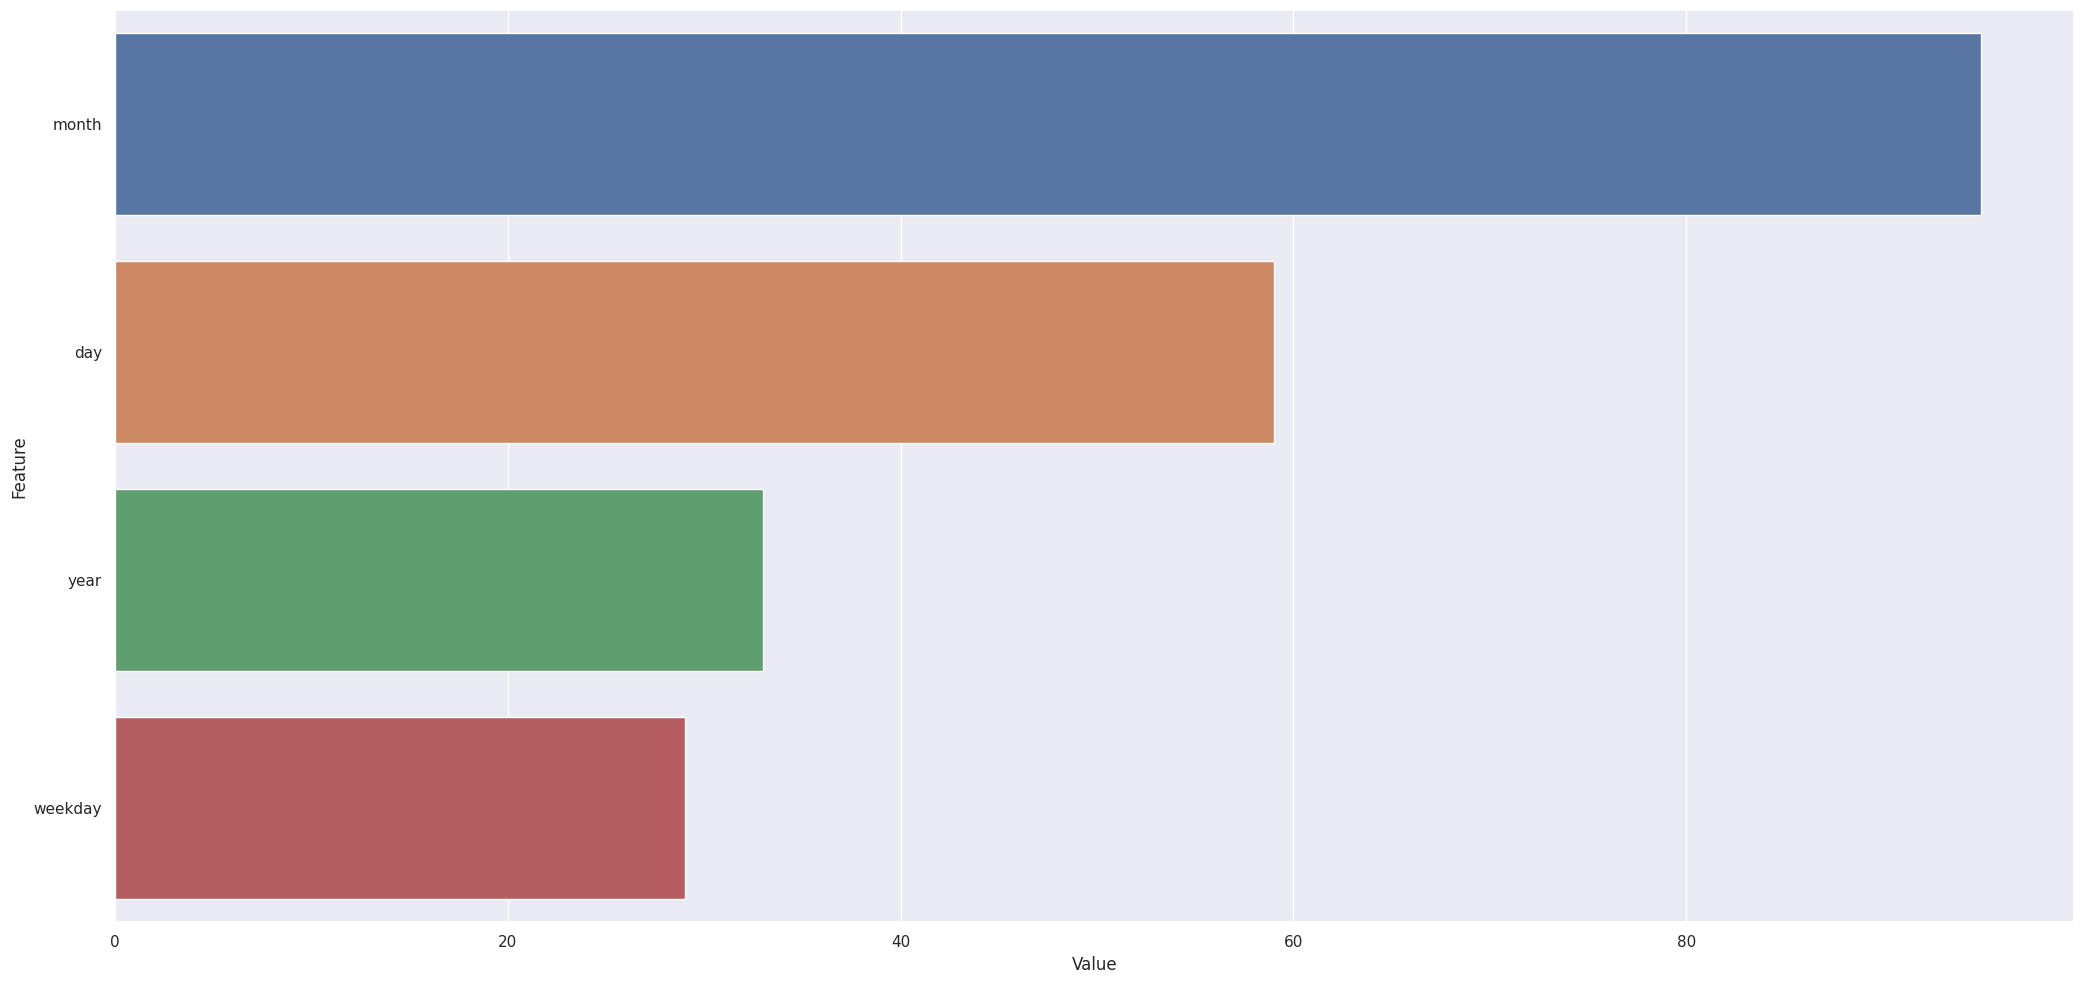

(18.52113044504691, 24.28588068332973, ['month', 'weekday'], 4)

In [39]:
use_c_mean_cols=False
use_lag_cols = False
use_gen_lags_cols = False
use_weather_cols = False
columns = ['AQI_PM25'] + settings.DATE_COLUMNS

optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8)
score_train, score_val, best_categories, best_features_count

train score: 18.339400388657484, val score: 24.352487244917747


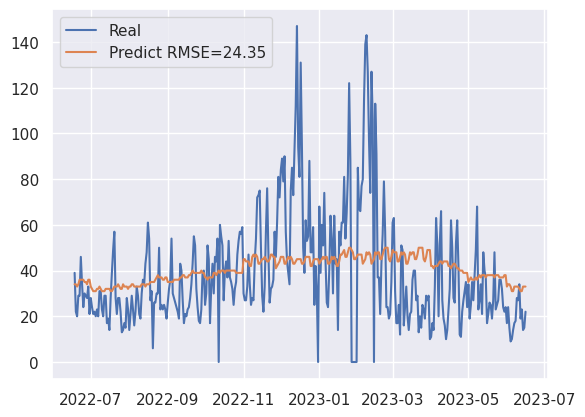

In [40]:
score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

print(f'train score: {score_train}, val score: {score_val}')
plt.plot(y_val.index, y_val, label="Real")
plt.plot(y_val.index, y_pred, label="Predict RMSE=%.2f" % score_val)
plt.legend()
plt.grid(True)
plt.show()

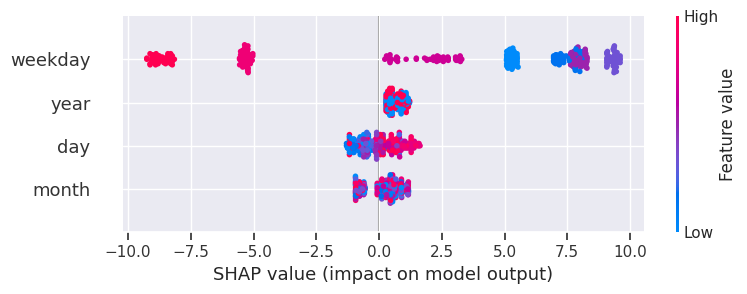

In [41]:
shap_values = shap.TreeExplainer(o_helper.best_model).shap_values(x_val)
#shap.summary_plot(shap_values, x_val, plot_size=(21, 80), max_display=210)
shap.summary_plot(shap_values, x_val, max_display=210)

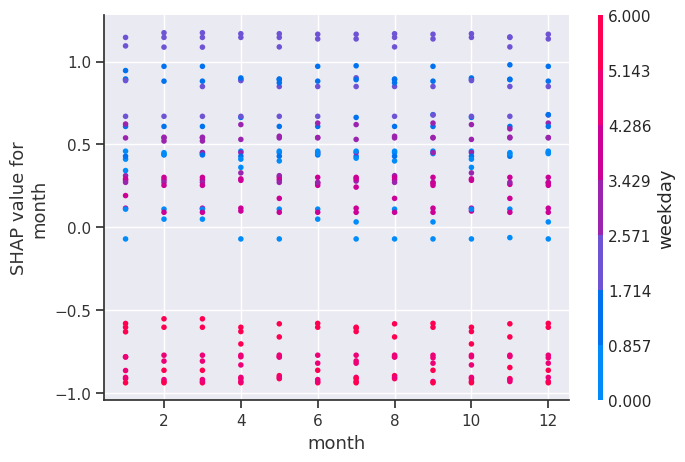

In [42]:
shap.dependence_plot("month", shap_values, x_val)

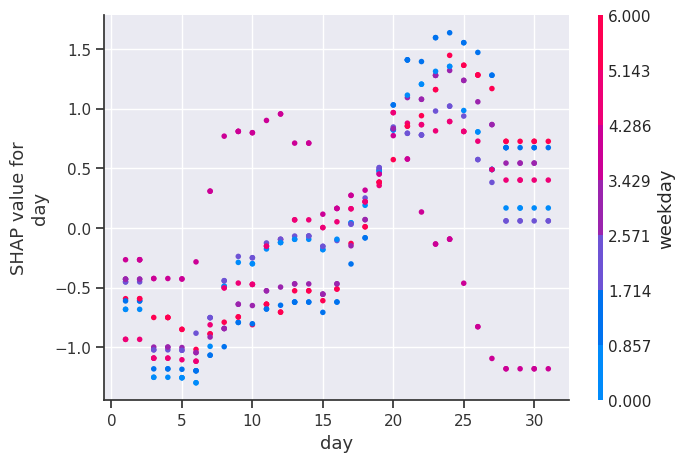

In [44]:
shap.dependence_plot("day", shap_values, x_val)

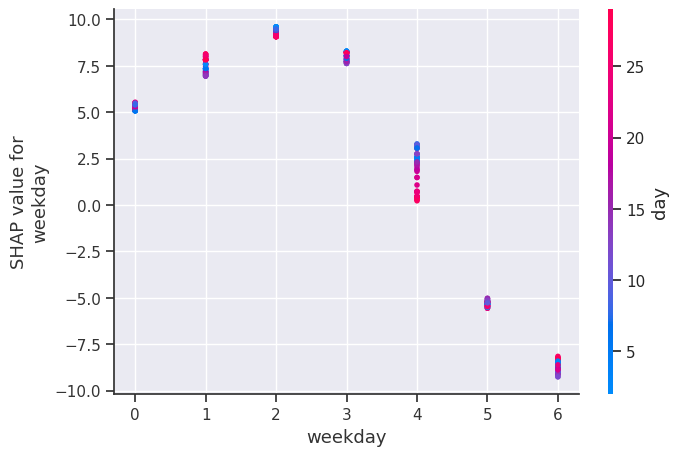

In [45]:
shap.dependence_plot("weekday", shap_values, x_val)

## AQI + date (selected)

In [ ]:
# df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')
# df_joint = df_joint[df_joint['Pollutant'] == 6001]
default_category = ['month'] # ['month', 'weekday']

columns = ['AQI_PM25', 'month', 'day']
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

## AQI + weather

In [11]:
# ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']
import numpy as np

df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')
# df_joint = df_joint[df_joint['Pollutant'] == 6001]

wv = df_joint.pop("wspd")
#max_wv = df_joint.pop('wpgt')
# Convert to radians.
wd_rad = df_joint.pop('wdir')*np.pi / 180

# Calculate the wind x and y components.
df_joint['Wx'] = wv*np.cos(wd_rad)
df_joint['Wy'] = wv*np.sin(wd_rad)

# # Calculate the max wind x and y components.
df_joint['wpgt'].fillna(0, inplace=True)
df_joint['wpgt'].mask(df_joint['wpgt'] > 0, 1, inplace=True)
df_joint['prcp'].fillna(0, inplace=True)

# df_joint['max_Wx'] = max_wv*np.cos(wd_rad)
# df_joint['max_Wy'] = max_wv*np.sin(wd_rad)

(-111.71347099259253,
 26.046893899271925,
 -107.8804449322823,
 37.418989916877834)

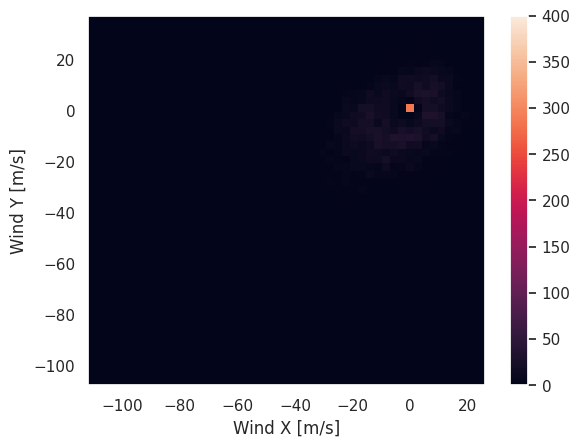

In [61]:
plt.hist2d(df_joint['Wx'].fillna(0), df_joint['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

[I 2023-06-17 18:08:58,476] A new study created in memory with name: _


run_params_search n_trials=50, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/50 [00:00<?, ?it/s]

Trial 7 finished with best value: 43.526117655523905 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 50, 'learning_rate': 0.10619395930162986, 'subsample': 0.17606466648337182, 'subsample_freq': 10, 'subsample_for_bin': 127335, 'min_child_samples': 383, 'reg_alpha': 0.48091931334062676, 'reg_lambda': 0.8392519045692446, 'max_depth': 9, 'max_bin': 293}. 
Trial 1 finished with best value: 34.55144668124691 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2700, 'num_leaves': 50, 'learning_rate': 0.061999064212128925, 'subsample': 0.5003417145985457, 'subsample_freq': 9, 'subsample_for_bin': 282443, 'min_child_samples': 471, 'reg_alpha': 0.2490234702759314, 'reg_lambda': 0.4212683223595678, 'max_depth': 4, 'max_bin': 55}. 
Trial 9 finished with best value: 29

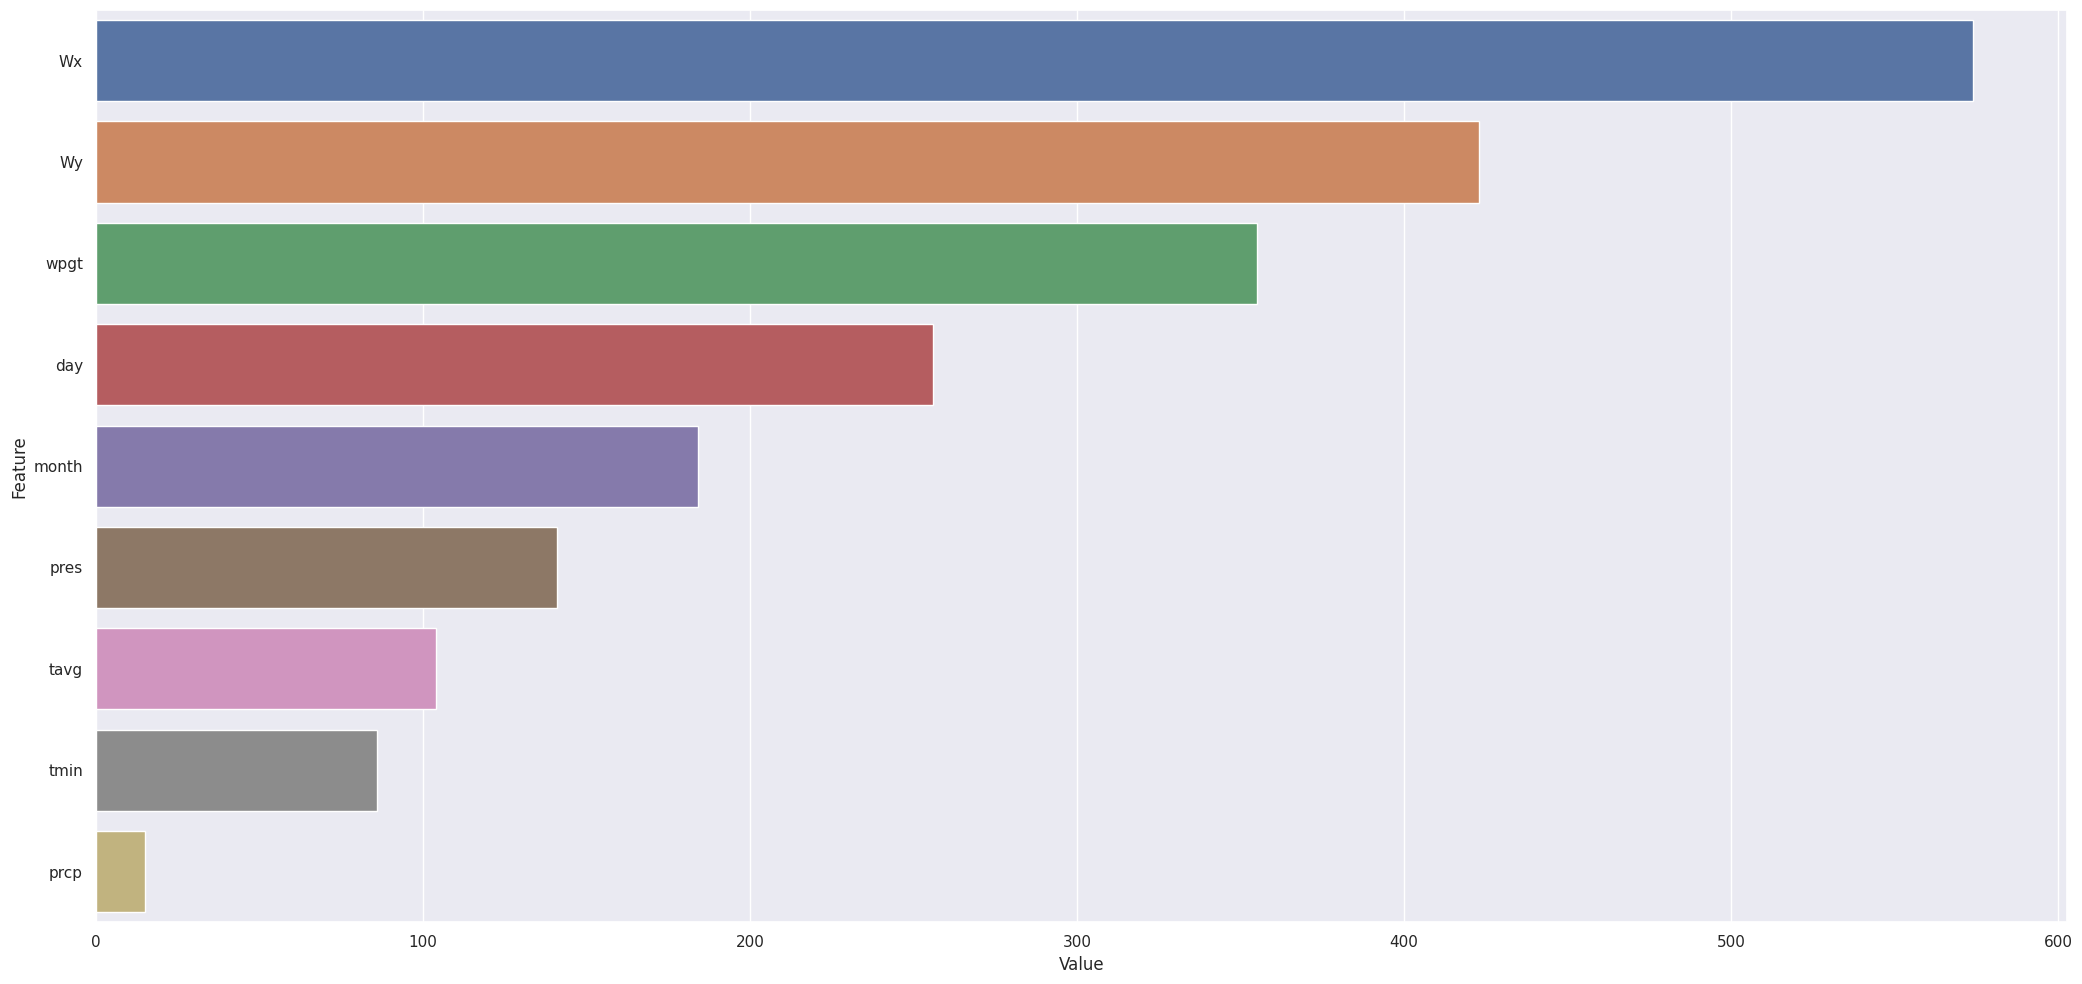

(10.053753529619105, 20.31958175255972, ['month', 'wpgt'], 9)

In [11]:
use_c_mean_cols=False
use_lag_cols = False
use_gen_lags_cols = False
use_weather_cols = True
# default_category = ['month', 'weekday']
# columns = ['AQI_PM25', 'weekday', 'month', 'tavg', 'tmin', 'tmax', 'prcp', 'Wx', 'Wy', 'max_Wx', 'max_Wy', 'pres']
default_category = ['month', 'wpgt']
columns = ['AQI_PM25', 'day', 'month', 'tavg', 'tmin', 'prcp', 'Wx', 'Wy', 'wpgt', 'pres']

optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

train score: 10.28053932417011, val score: 20.375555763870693


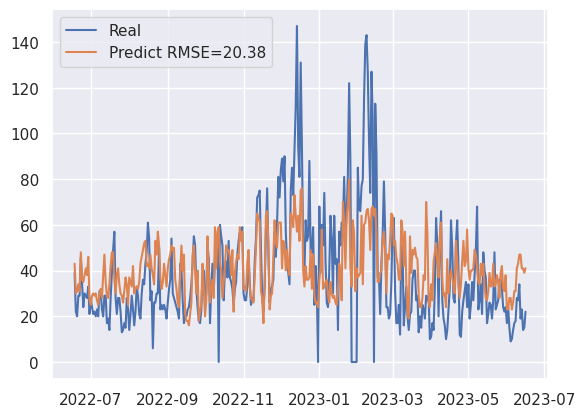

In [12]:
score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

print(f'train score: {score_train}, val score: {score_val}')
plt.plot(y_val.index, y_val, label="Real")
plt.plot(y_val.index, y_pred, label="Predict RMSE=%.2f" % score_val)
plt.legend()
plt.grid(True)
plt.show()

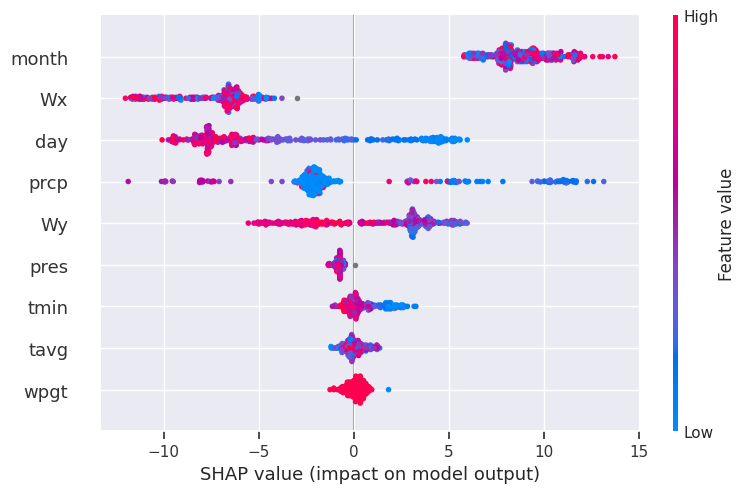

In [13]:
shap_values = shap.TreeExplainer(o_helper.best_model).shap_values(x_val)
#shap.summary_plot(shap_values, x_val, plot_size=(21, 80), max_display=210)
shap.summary_plot(shap_values, x_val, max_display=210)

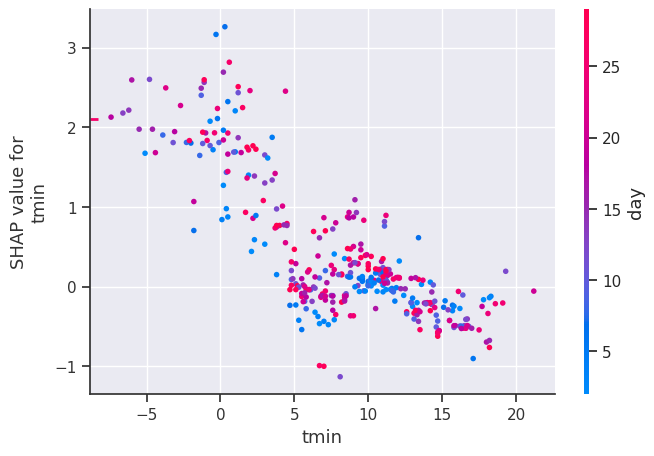

In [14]:
shap.dependence_plot("tmin", shap_values, x_val)

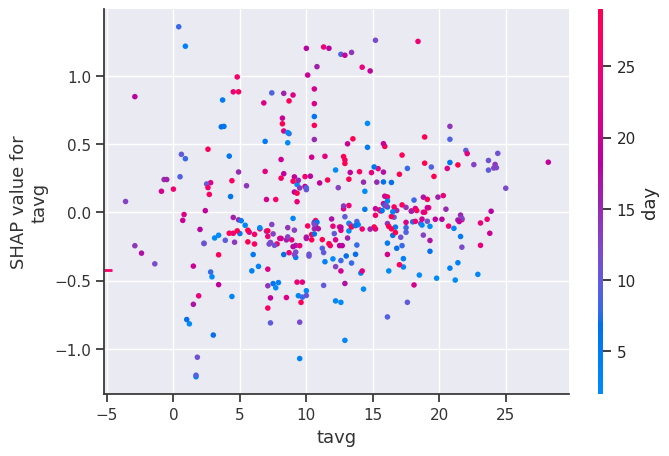

In [15]:
shap.dependence_plot("tavg", shap_values, x_val)

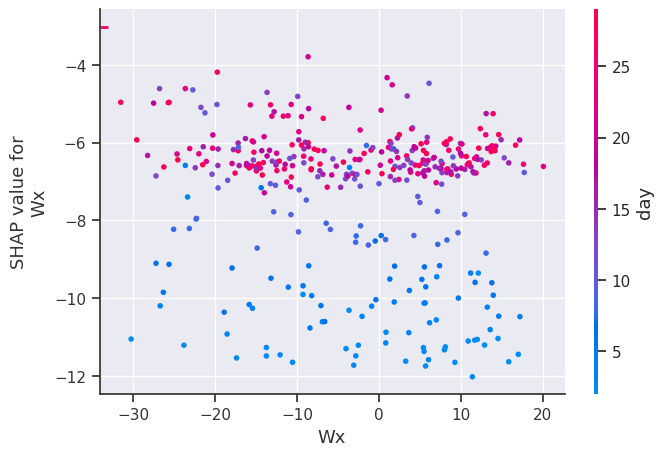

In [16]:
shap.dependence_plot("Wx", shap_values, x_val)

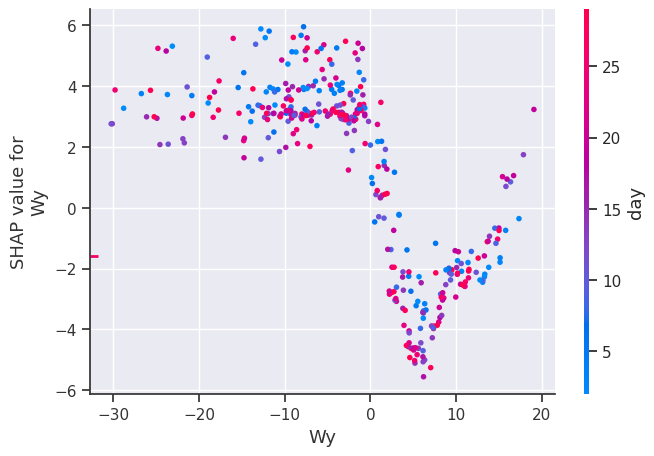

In [17]:
shap.dependence_plot("Wy", shap_values, x_val)

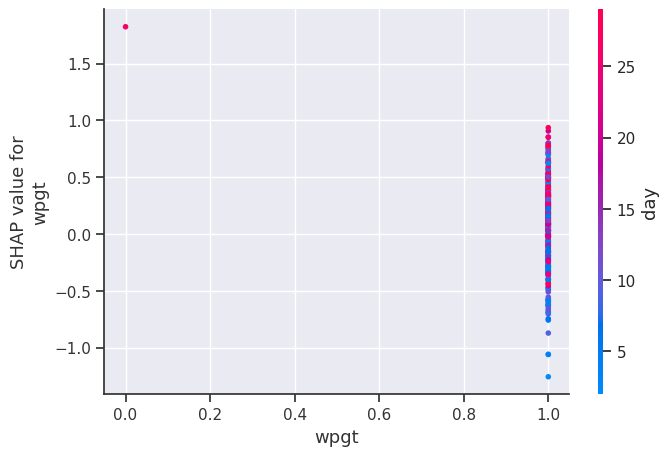

In [18]:
shap.dependence_plot("wpgt", shap_values, x_val)

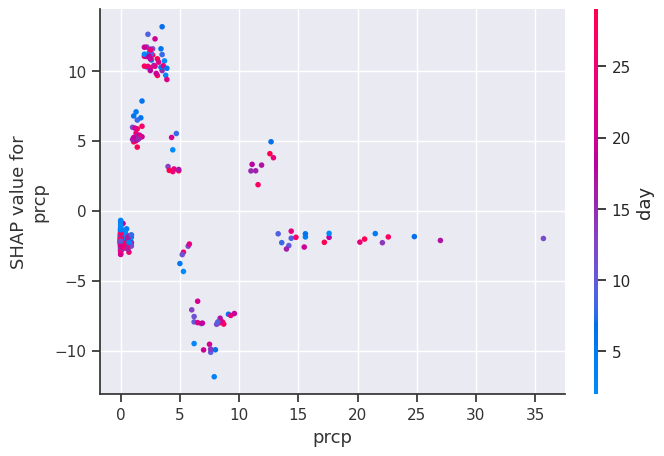

In [20]:
shap.dependence_plot("prcp", shap_values, x_val)

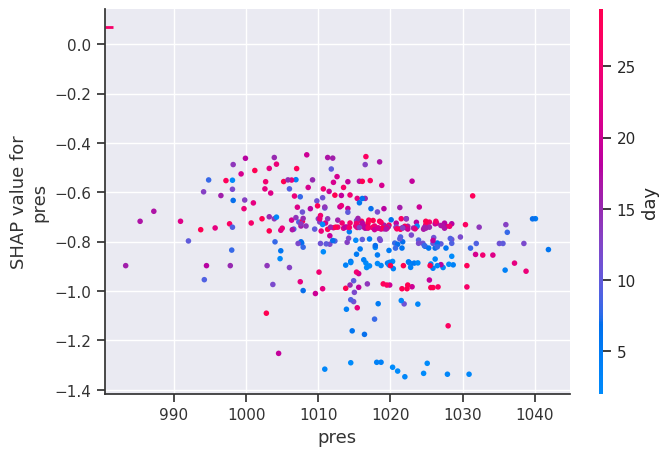

In [21]:
shap.dependence_plot("pres", shap_values, x_val)

## AQI + weather (selected)

run_params_search n_trials=50, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/50 [00:00<?, ?it/s]

Trial 1 finished with best value: 32.94708696948434 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1400, 'num_leaves': 25, 'learning_rate': 0.1274039147505442, 'subsample': 0.3941757881441529, 'subsample_freq': 6, 'subsample_for_bin': 325533, 'min_child_samples': 339, 'reg_alpha': 0.5271884973128356, 'reg_lambda': 0.9903612234378354, 'max_depth': 4, 'max_bin': 162}. 
Trial 4 finished with best value: 29.08966610557357 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2300, 'num_leaves': 131, 'learning_rate': 0.12258485942438192, 'subsample': 0.7586747409490421, 'subsample_freq': 7, 'subsample_for_bin': 218730, 'min_child_samples': 533, 'reg_alpha': 0.9433488030037529, 'reg_lambda': 0.3308995172965802, 'max_depth': 11, 'max_bin': 83}. 
Trial 2 finished with best value: 20.217

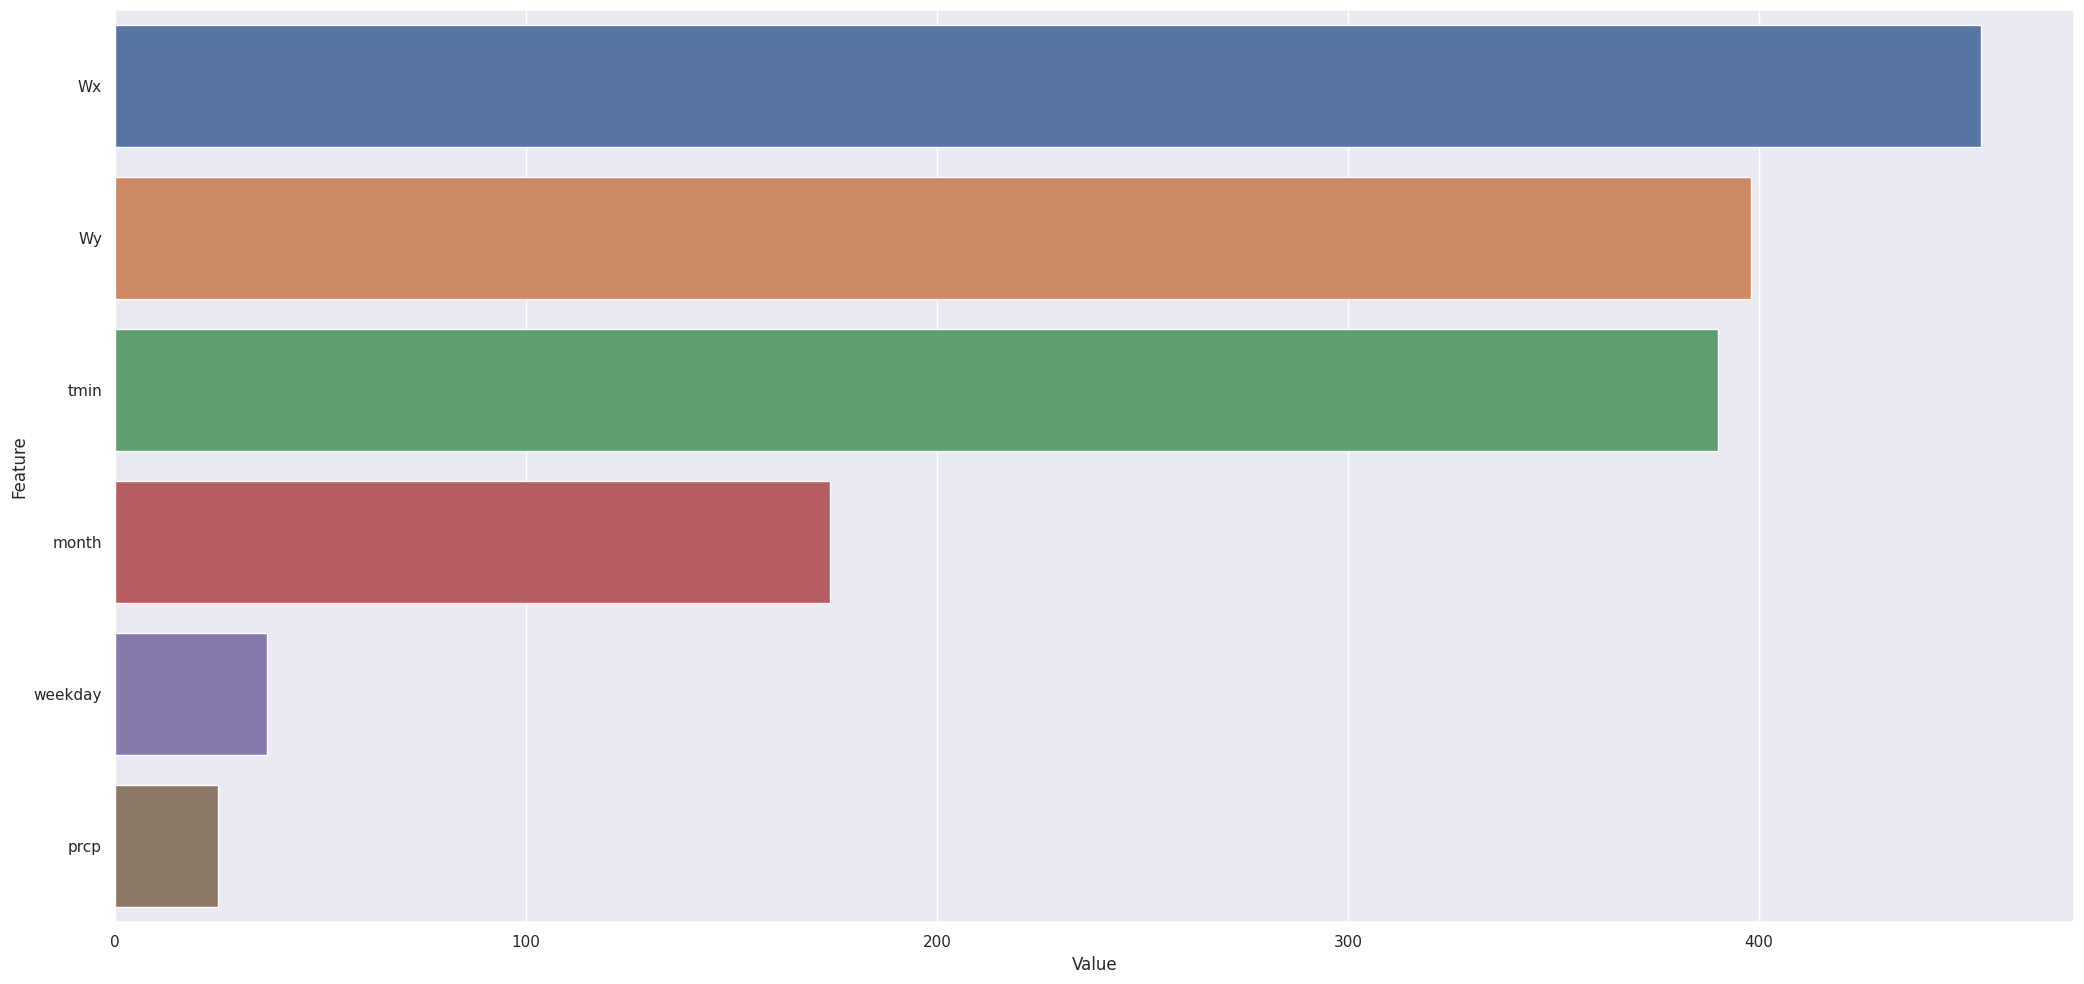

(12.6735833705873, 20.170729276334523, ['month', 'weekday'], 6)

In [31]:
use_c_mean_cols=False
use_lag_cols = False
use_gen_lags_cols = False
use_weather_cols = True
# columns = ['AQI_PM25', 'weekday', 'day', 'month', 'year', 'is_weekend', 'tavg', 'prcp', 'Wx', 'Wy', 'max_Wx', 'max_Wy']
default_category = ['month', 'weekday']
columns = ['AQI_PM25', 'weekday', 'month', 'tmin', 'Wx', 'Wy', 'prcp']

optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

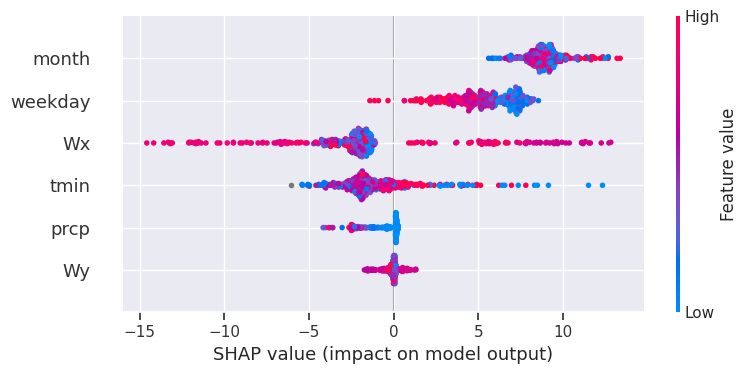

In [32]:
score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)
shap_values = shap.TreeExplainer(o_helper.best_model).shap_values(x_val)
shap.summary_plot(shap_values, x_val, max_display=210)

## AQI Outliers interpolation

In [12]:
# IQR
# Calculate the upper and lower limits
Q1 = df_joint['AQI_PM25'].quantile(0.25)
Q3 = df_joint['AQI_PM25'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [13]:
df_joint[df_joint['AQI_PM25']>=upper].shape[0], df_joint[df_joint['AQI_PM25']>=upper].shape[0]/df_joint.shape[0]

(83, 0.026869537067011978)

In [14]:
upper_array = df_joint[df_joint['AQI_PM25']>=upper].index
lower_array = df_joint[df_joint['AQI_PM25']<=lower].index
df_joint.loc[upper_array, 'AQI_PM25'] = np.nan
df_joint.loc[lower_array, 'AQI_PM25'] = np.nan
df_joint['AQI_PM25'] = df_joint['AQI_PM25'].interpolate(method='time')
df_joint['AQI_PM25'].isna().sum()

1

In [22]:
df_joint.drop(index=df_joint[df_joint['AQI_PM25'].isna()].index, inplace=True)
df_joint['AQI_PM25'].isna().sum()

0

run_params_search n_trials=50, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/50 [00:00<?, ?it/s]

Trial 4 finished with best value: 41.73052492261459 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 114, 'learning_rate': 0.13129777701253192, 'subsample': 0.30524193036482333, 'subsample_freq': 8, 'subsample_for_bin': 117472, 'min_child_samples': 505, 'reg_alpha': 0.6047326138540243, 'reg_lambda': 0.13249163966326494, 'max_depth': 8, 'max_bin': 164}. 
Trial 10 finished with best value: 32.34171318916499 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2900, 'num_leaves': 51, 'learning_rate': 0.08037647805213179, 'subsample': 0.5960510560937573, 'subsample_freq': 4, 'subsample_for_bin': 166923, 'min_child_samples': 573, 'reg_alpha': 0.24772960825147727, 'reg_lambda': 0.9887090051802232, 'max_depth': 11, 'max_bin': 164}. 
Trial 3 finished with best value: 3

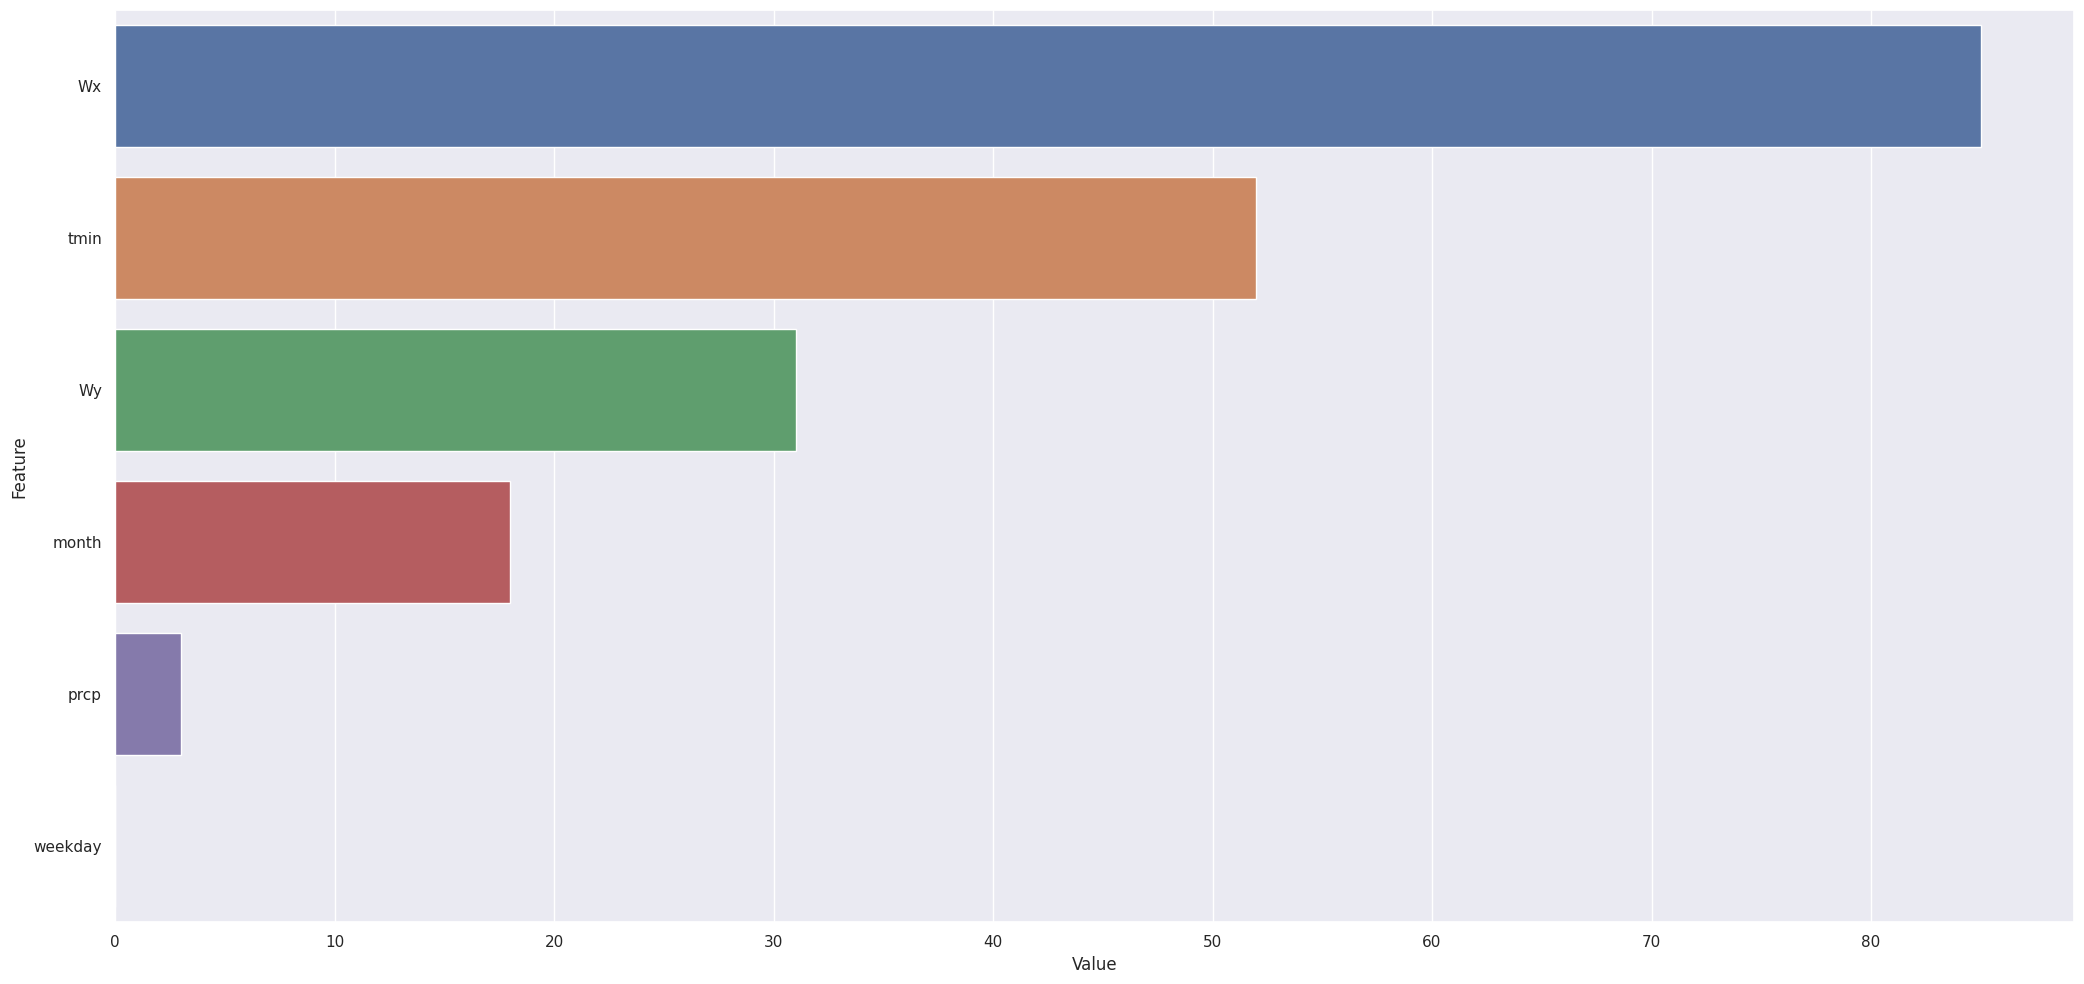

(12.362618282295387, 12.737829614026545, ['month', 'weekday'], 6)

In [23]:
use_c_mean_cols=False
use_lag_cols = False
use_gen_lags_cols = False
use_weather_cols = True
default_category = ['month', 'weekday']
columns = ['AQI_PM25', 'weekday', 'month', 'tmin', 'Wx', 'Wy', 'prcp']

optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

## General features selection

In [46]:
# cols = [x for x in df_joint.columns.values if x.find(settings.POL_NAMES[pol_id]) > 0]
# all_values_columns = [x for x in df_joint.columns.values if
#                       [p for p in settings.POL_CODES if x.endswith(settings.POL_NAMES[p])]] + [
#                          'AQI'] + ['Pollutant']
#
# cols = [x for x in cols if x not in all_values_columns]
# cols = [x for x in cols if not x.startswith('C_min')]
# cols = [x for x in cols if not x.startswith('C_median')]
# cols = [x for x in cols if not x.startswith('C_mean')]
# cols = [x for x in cols if not x.startswith('C_max')]
# #cols = [x for x in cols if x.endswith('_filtNoFilter')]
# cols

['AQI_PM25']

In [24]:
import re
cols = [x for x in df_joint.columns.values if x.startswith('AQI')]
regular_expr = re.compile(r".*_lag\d+d_.*")
cols_gen_lags = list(filter(regular_expr.match, cols))
#cols = [x for x in cols if x not in df_gen_lags]
len(cols_gen_lags)

195

## AQI + date + weather + outliers interpolation + gen features

run_params_search n_trials=50, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/50 [00:00<?, ?it/s]

Trial 2 finished with best value: 21.763738315157966 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1100, 'num_leaves': 82, 'learning_rate': 0.11002624027431593, 'subsample': 0.681688559275695, 'subsample_freq': 9, 'subsample_for_bin': 176147, 'min_child_samples': 302, 'reg_alpha': 0.6260929003283798, 'reg_lambda': 0.2088057710154666, 'max_depth': 6, 'max_bin': 133}. 
Trial 4 finished with best value: 19.757626483101717 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2900, 'num_leaves': 78, 'learning_rate': 0.14469584616368755, 'subsample': 0.5009121772022495, 'subsample_freq': 10, 'subsample_for_bin': 163313, 'min_child_samples': 154, 'reg_alpha': 0.7847007546699174, 'reg_lambda': 0.8520480801219488, 'max_depth': 6, 'max_bin': 255}. 
Trial 5 finished with best value: 19.3

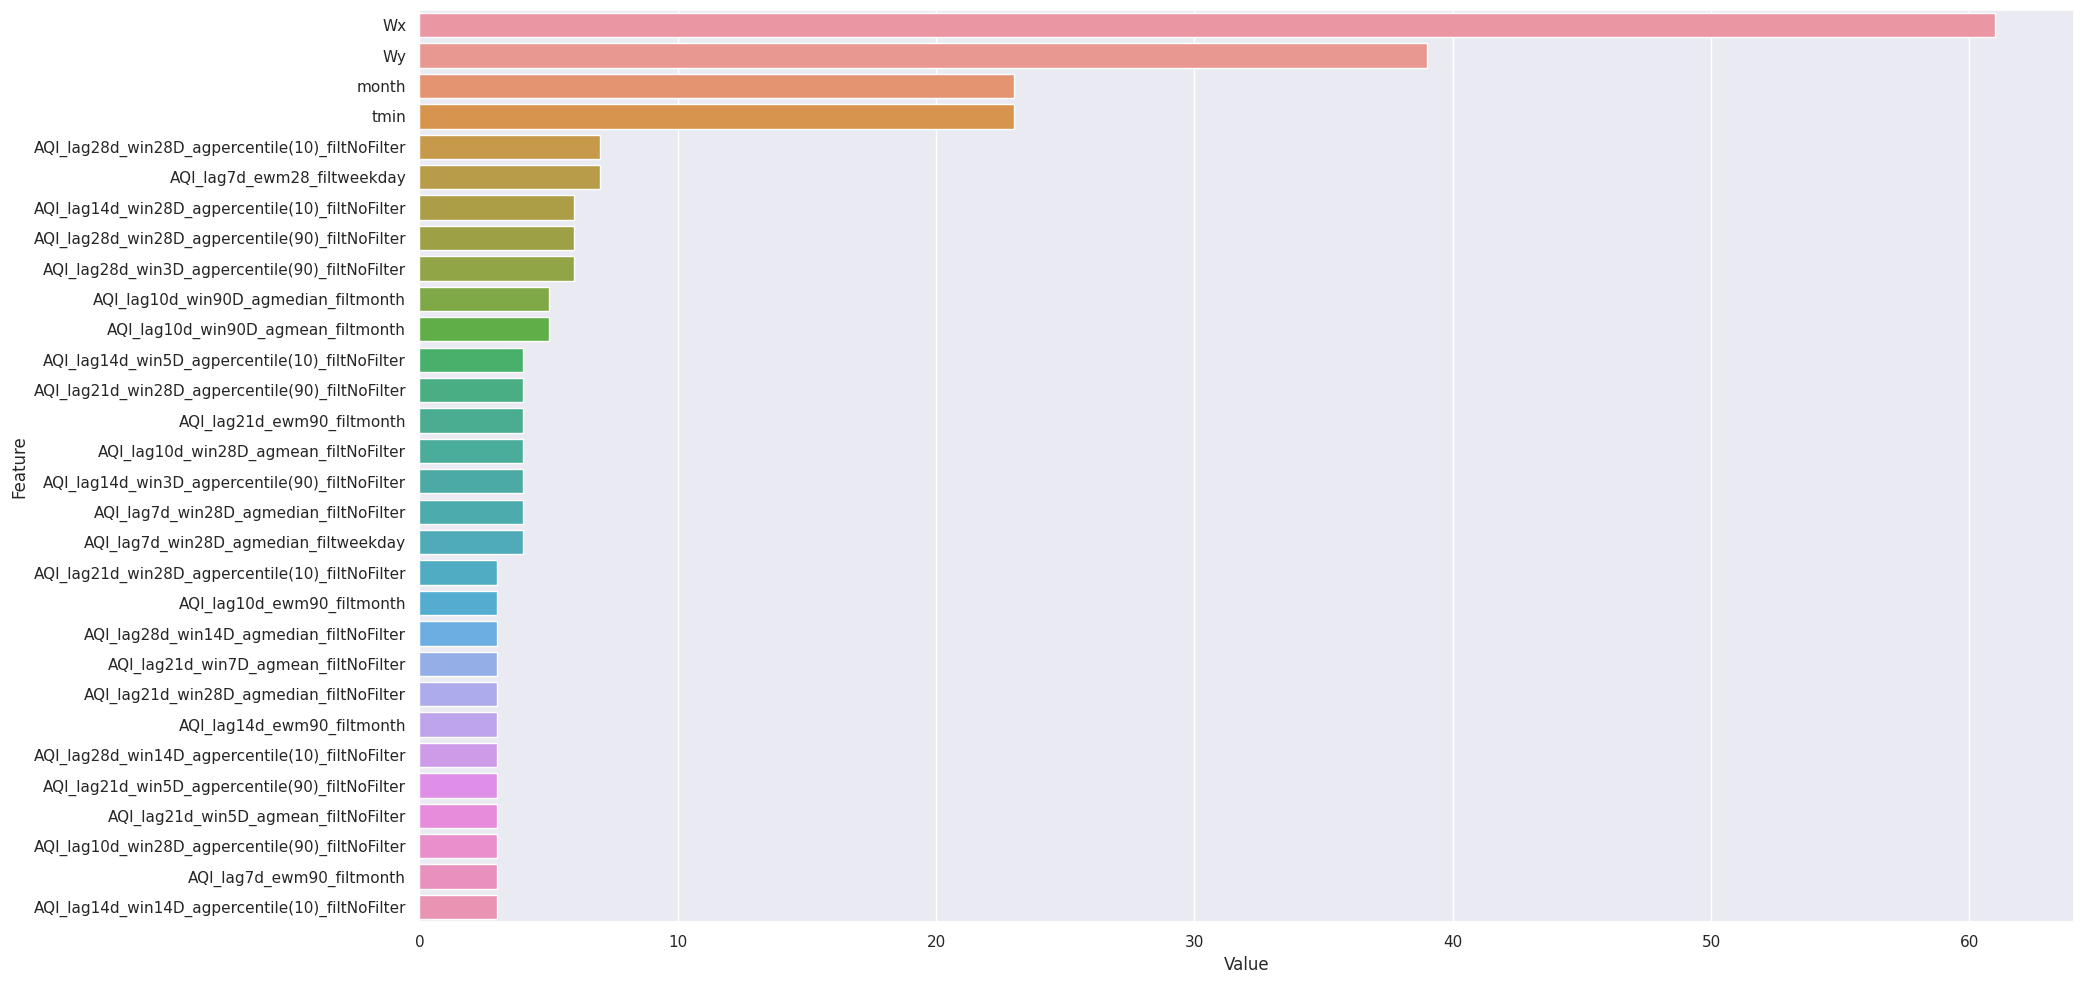

(7.598069003832253, 14.489348647548569, ['month', 'weekday'], 201)

In [88]:
# TRAIN_DATE_FROM = '2015-04-01'
# TRAIN_DATE_TO = '2023-04-30'
# VAL_DATE_FROM = '2023-05-01'
# VAL_DATE_TO = '2023-05-07'

# TRAIN_DATE_FROM = '2015-04-01'
# TRAIN_DATE_TO = '2022-06-17'
# VAL_DATE_FROM = '2022-06-18'
# VAL_DATE_TO = '2023-06-17'

TRAIN_DATE_FROM = '2015-04-01'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_FROM = '2023-05-02'
VAL_DATE_TO = '2023-05-08'

# default_category = []
# columns = ['AQI_PM25', 'weekday', 'month', 'tmin', 'Wx', 'Wy', 'prcp']
default_category = ['month', 'weekday']

use_c_mean_cols=False
use_lag_cols = False
use_gen_lags_cols = False
use_weather_cols = True
columns = ['AQI_PM25', 'weekday', 'month', 'tmin', 'Wx', 'Wy', 'prcp'] + cols_gen_lags # shap_cols
# cols_gen_lags
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

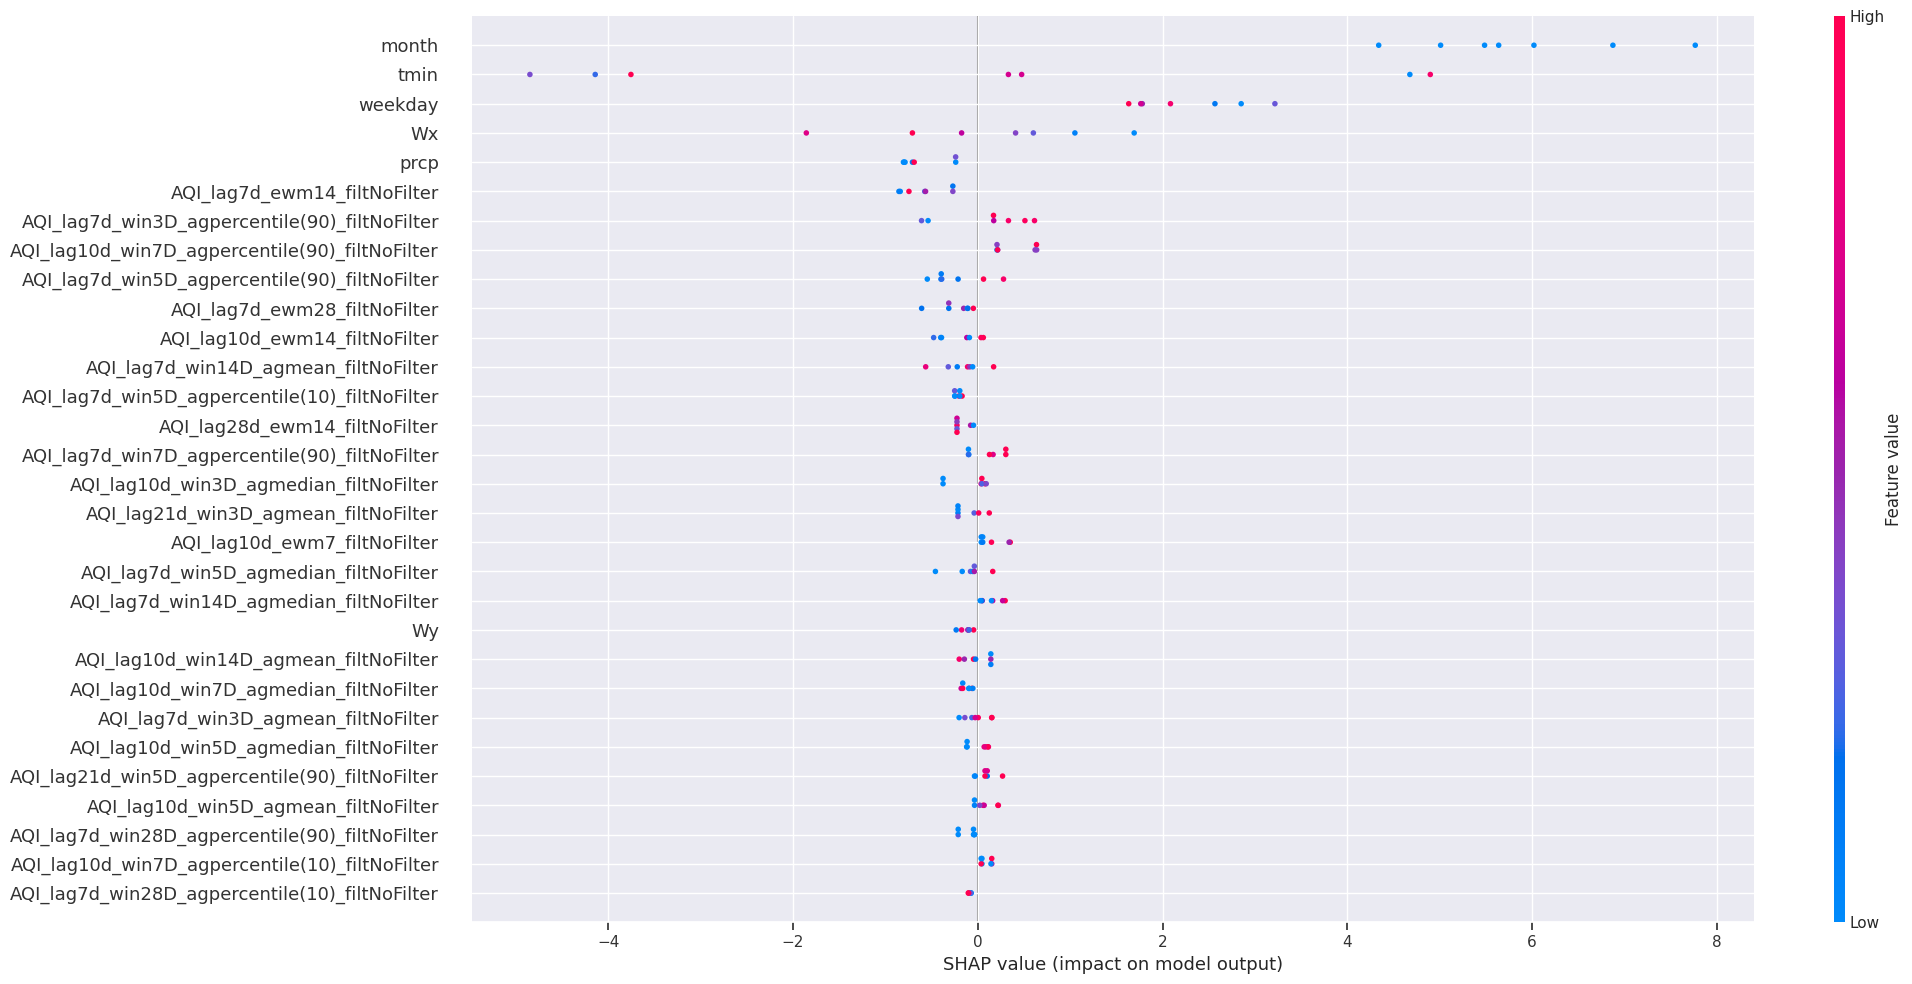

In [89]:
score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

shap_values = shap.TreeExplainer(o_helper.best_model).shap_values(x_val)
shap.summary_plot(shap_values, x_val, plot_size=(21, 10), max_display=30)

In [90]:
shap_imp = get_shap_feature_importance(shap_values, x_val)
shap_cols = shap_imp[:20]['feature'].values.tolist()
shap_cols

['month',
 'tmin',
 'weekday',
 'Wx',
 'prcp',
 'AQI_lag7d_ewm14_filtNoFilter',
 'AQI_lag7d_win3D_agpercentile(90)_filtNoFilter',
 'AQI_lag10d_win7D_agpercentile(90)_filtNoFilter',
 'AQI_lag7d_win5D_agpercentile(90)_filtNoFilter',
 'AQI_lag7d_ewm28_filtNoFilter',
 'AQI_lag10d_ewm14_filtNoFilter',
 'AQI_lag7d_win14D_agmean_filtNoFilter',
 'AQI_lag7d_win5D_agpercentile(10)_filtNoFilter',
 'AQI_lag28d_ewm14_filtNoFilter',
 'AQI_lag7d_win7D_agpercentile(90)_filtNoFilter',
 'AQI_lag10d_win3D_agmedian_filtNoFilter',
 'AQI_lag21d_win3D_agmean_filtNoFilter',
 'AQI_lag10d_ewm7_filtNoFilter',
 'AQI_lag7d_win5D_agmedian_filtNoFilter',
 'AQI_lag7d_win14D_agmedian_filtNoFilter']

In [92]:
feat_imp_df[:15]

Value                                          Feature
0      61                                               Wx
1      39                                               Wy
8      23                                            month
11     23                                             tmin
33      7  AQI_lag28d_win28D_agpercentile(10)_filtNoFilter
12      7                      AQI_lag7d_ewm28_filtweekday
27      6  AQI_lag14d_win28D_agpercentile(10)_filtNoFilter
24      6  AQI_lag28d_win28D_agpercentile(90)_filtNoFilter
61      6   AQI_lag28d_win3D_agpercentile(90)_filtNoFilter
9       5             AQI_lag10d_win90D_agmedian_filtmonth
3       5               AQI_lag10d_win90D_agmean_filtmonth
28      4   AQI_lag14d_win5D_agpercentile(10)_filtNoFilter
34      4  AQI_lag21d_win28D_agpercentile(90)_filtNoFilter
37      4                       AQI_lag21d_ewm90_filtmonth
47      4            AQI_lag10d_win28D_agmean_filtNoFilter

In [93]:
feat_selected = feat_imp_df[:30].merge(shap_imp[:30], left_on='Feature', right_on='feature')
cols_selected = feat_selected['feature'].values.tolist()
cols_selected

['Wx', 'Wy', 'month', 'tmin', 'AQI_lag21d_win5D_agpercentile(90)_filtNoFilter']

run_params_search n_trials=100, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 25.88777660749157 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2900, 'num_leaves': 60, 'learning_rate': 0.08597469270399588, 'subsample': 0.8825792806546126, 'subsample_freq': 5, 'subsample_for_bin': 53011, 'min_child_samples': 562, 'reg_alpha': 0.7498813215832513, 'reg_lambda': 0.23241611845407917, 'max_depth': 3, 'max_bin': 341}. 
Trial 1 finished with best value: 23.103647670182536 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2600, 'num_leaves': 75, 'learning_rate': 0.13011704791414241, 'subsample': 0.6387971087552478, 'subsample_freq': 4, 'subsample_for_bin': 432141, 'min_child_samples': 346, 'reg_alpha': 0.06959723634387993, 'reg_lambda': 0.2524698885060427, 'max_depth': 8, 'max_bin': 184}. 
Trial 6 finished with best value: 19.0

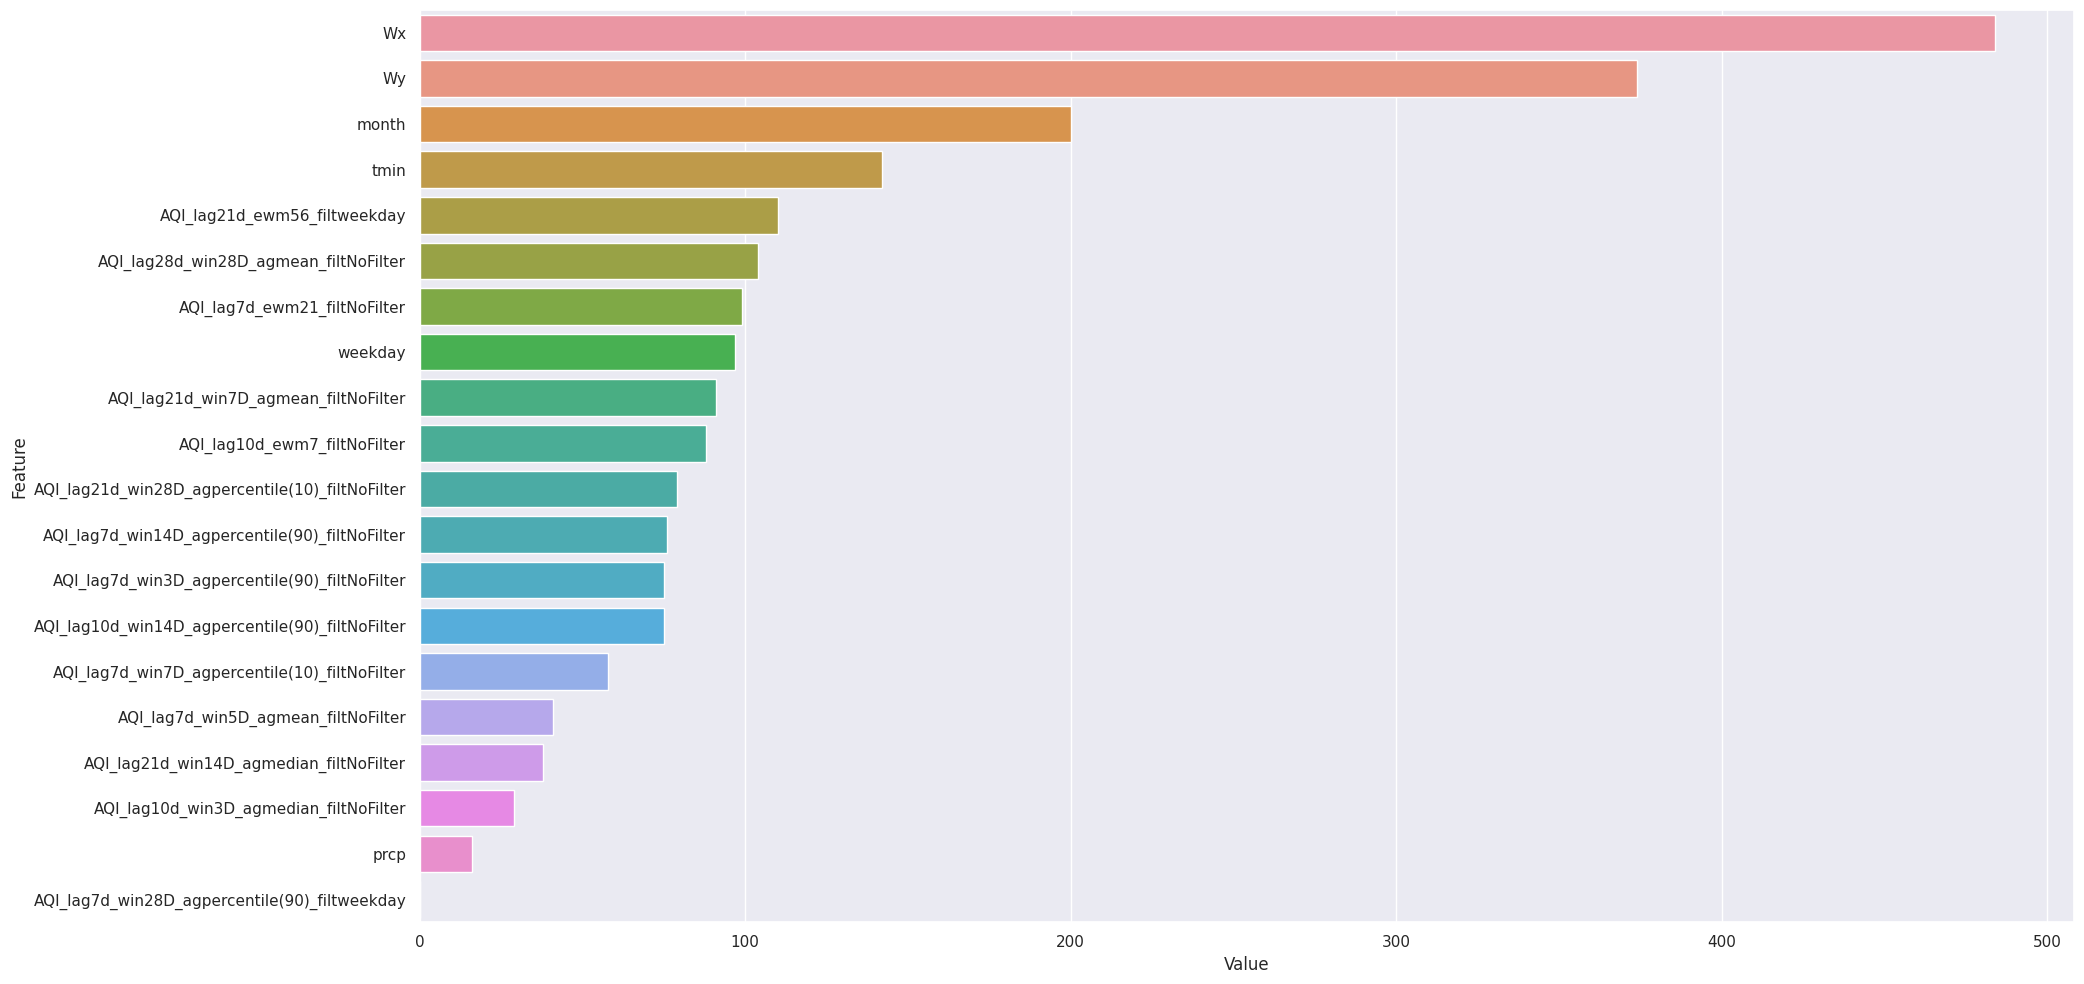

(8.493364703025188, 6.6805487904418985, ['month', 'weekday'], 20)

In [132]:
TRAIN_DATE_FROM = '2015-04-01'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_FROM = '2023-05-02'
VAL_DATE_TO = '2023-05-08'

TRAIN_DATE_FROM = '2015-04-01'
TRAIN_DATE_TO = '2023-04-30'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_TO = '2023-05-07'

default_category = ['month', 'weekday']
columns = ['AQI_PM25'] + \
          [
         'month',
         'weekday',
         'Wx',
         'Wy',
         'tmin',
         'prcp',
         'AQI_lag21d_win7D_agmean_filtNoFilter',            #!
         'AQI_lag7d_win7D_agpercentile(10)_filtNoFilter',   #!
         'AQI_lag7d_win3D_agpercentile(90)_filtNoFilter',   #!
         'AQI_lag10d_win3D_agmedian_filtNoFilter',          #!
         'AQI_lag10d_ewm7_filtNoFilter',                    #!

         'AQI_lag28d_win28D_agmean_filtNoFilter',
         'AQI_lag7d_ewm21_filtNoFilter',
         'AQI_lag7d_win14D_agpercentile(90)_filtNoFilter',
         'AQI_lag21d_win14D_agmedian_filtNoFilter',
         'AQI_lag10d_win14D_agpercentile(90)_filtNoFilter',

         'AQI_lag7d_win5D_agmean_filtNoFilter',
         'AQI_lag21d_win28D_agpercentile(10)_filtNoFilter',
         'AQI_lag7d_win28D_agpercentile(90)_filtweekday',
         'AQI_lag21d_ewm56_filtweekday'
        ]

# columns = ['AQI_PM25'] + shap_cols
# cols_gen_lags
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=100, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

In [109]:
best_params

{'n_jobs': -1,
 'verbosity': -1,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'extra_trees': False,
 'n_estimators': 1900,
 'num_leaves': 141,
 'learning_rate': 0.06495001902469816,
 'subsample': 0.6852902680984172,
 'subsample_freq': 1,
 'subsample_for_bin': 497690,
 'min_child_samples': 48,
 'reg_alpha': 0.38477231742053275,
 'reg_lambda': 0.018054658468185325,
 'max_depth': 4,
 'max_bin': 160}

In [80]:
best_params

{'n_jobs': -1,
 'verbosity': -1,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'extra_trees': True,
 'n_estimators': 1000,
 'num_leaves': 40,
 'learning_rate': 0.09952411331294833,
 'subsample': 0.8238546007900154,
 'subsample_freq': 4,
 'subsample_for_bin': 447615,
 'min_child_samples': 78,
 'reg_alpha': 0.22852659972978506,
 'reg_lambda': 0.7511473030652365,
 'max_depth': 5,
 'max_bin': 169}

In [81]:
TRAIN_DATE_FROM = '2015-04-01'
TRAIN_DATE_TO = '2023-04-30'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_TO = '2023-05-07'

score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

score_train, score_val

(9.623158101971255, 5.509839994275984)

In [108]:
TRAIN_DATE_FROM = '2015-04-01'
TRAIN_DATE_TO = '2023-04-30'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_TO = '2023-05-07'

score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

score_train, score_val

(9.630485026713208, 4.428761066272438)

In [107]:
TRAIN_DATE_FROM = '2015-04-01'
VAL_DATE_FROM = '2023-05-01'
VAL_DATE_FROM = '2023-05-02'
VAL_DATE_TO = '2023-05-08'

score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

score_train, score_val

(9.745490614372851, 13.960808852991113)

## AQI + date+ weather + lags

In [119]:
import re
cols = [x for x in df_joint.columns.values if x.startswith('AQI_lag')]
regular_expr = re.compile(r".*_lag\d+d_.*")
cols_gen_lags = list(filter(regular_expr.match, cols))
cols_lags = [x for x in cols if x not in cols_gen_lags]
cols_lags

['AQI_lag7',
 'AQI_lag8',
 'AQI_lag9',
 'AQI_lag10',
 'AQI_lag11',
 'AQI_lag12',
 'AQI_lag13',
 'AQI_lag14',
 'AQI_lag21',
 'AQI_lag28']

run_params_search n_trials=150, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 1 finished with best value: 41.73052492261459 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2900, 'num_leaves': 125, 'learning_rate': 0.09682973858649398, 'subsample': 0.32956648520538634, 'subsample_freq': 8, 'subsample_for_bin': 240028, 'min_child_samples': 558, 'reg_alpha': 0.9376466155074226, 'reg_lambda': 0.5144316099736689, 'max_depth': 4, 'max_bin': 221}. 
Trial 6 finished with best value: 27.624081003041944 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2900, 'num_leaves': 149, 'learning_rate': 0.12080260920037889, 'subsample': 0.4609111305186214, 'subsample_freq': 9, 'subsample_for_bin': 224327, 'min_child_samples': 356, 'reg_alpha': 0.2393580763409996, 'reg_lambda': 0.7314199647663371, 'max_depth': 5, 'max_bin': 229}. 
Trial 3 finished with best value: 25

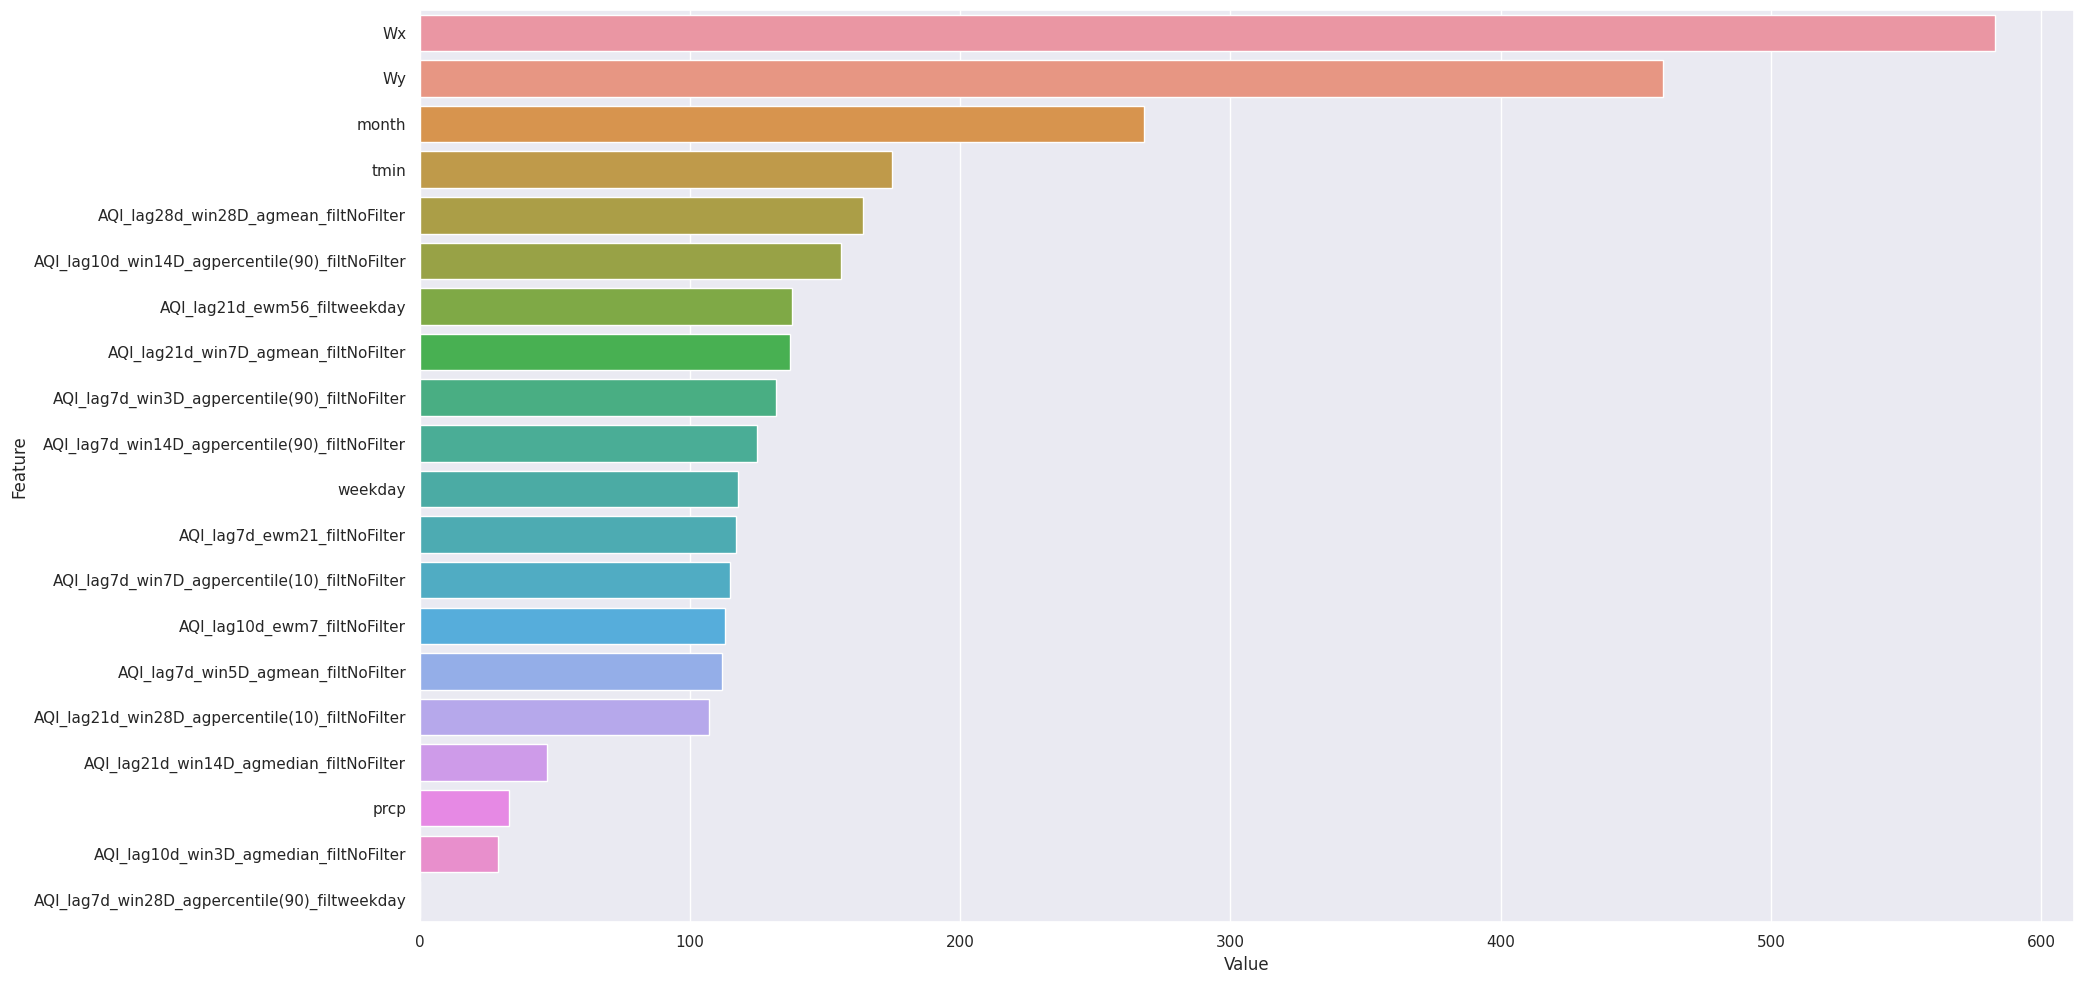

(11.442303724274728, 15.271877626387848, ['month', 'weekday'], 20)

In [25]:
columns = ['AQI_PM25'] + \
          [
         'month',
         'weekday',
         'Wx',
         'Wy',
         'tmin',
         'prcp'
          ] + \
         [
         'AQI_lag21d_win7D_agmean_filtNoFilter',            #!
         'AQI_lag7d_win7D_agpercentile(10)_filtNoFilter',   #!
         'AQI_lag7d_win3D_agpercentile(90)_filtNoFilter',   #!
         'AQI_lag10d_win3D_agmedian_filtNoFilter',          #!
         'AQI_lag10d_ewm7_filtNoFilter',                    #!

         'AQI_lag28d_win28D_agmean_filtNoFilter',
         'AQI_lag7d_ewm21_filtNoFilter',
         'AQI_lag7d_win14D_agpercentile(90)_filtNoFilter',
         'AQI_lag21d_win14D_agmedian_filtNoFilter',
         'AQI_lag10d_win14D_agpercentile(90)_filtNoFilter',

         'AQI_lag7d_win5D_agmean_filtNoFilter',
         'AQI_lag21d_win28D_agpercentile(10)_filtNoFilter',
         'AQI_lag7d_win28D_agpercentile(90)_filtweekday',
         'AQI_lag21d_ewm56_filtweekday'
        ]  \
          # + \
          # [
          # #     # 'AQI_lag21',
          #  'AQI_lag7',
          #  'AQI_lag8',
          #  'AQI_lag9',
          # #  # 'AQI_lag14',
          # ]

TRAIN_DATE_FROM = '2015-04-01'
VAL_DATE_FROM = '2023-06-9'
VAL_DATE_FROM = '2023-06-10'
VAL_DATE_TO = '2023-06-16'

default_category = ['month', 'weekday']
categories = [['month', 'weekday']]
use_c_mean_cols = False
use_lag_cols = False
use_gen_lags_cols = False
use_weather_cols = True
# TRAIN_DATE_FROM = '2015-04-01'
# TRAIN_DATE_TO = '2023-04-30'
# VAL_DATE_FROM = '2023-05-01'
# VAL_DATE_TO = '2023-05-07'

optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=150, n_jobs=8, df_filtered=True)
# (9.161835278387002, 16.351001556657213, ['month', 'weekday'], 20) - np simple lags
score_train, score_val, best_categories, best_features_count

In [27]:
df_joint.index.max()

Timestamp('2023-06-16 00:00:00')

In [26]:
best_params

{'n_jobs': -1,
 'verbosity': -1,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'extra_trees': True,
 'n_estimators': 1300,
 'num_leaves': 116,
 'learning_rate': 0.05537186900769092,
 'subsample': 0.8341189415059049,
 'subsample_freq': 4,
 'subsample_for_bin': 444122,
 'min_child_samples': 35,
 'reg_alpha': 0.6001403310052862,
 'reg_lambda': 0.1505947941794114,
 'max_depth': 7,
 'max_bin': 157}

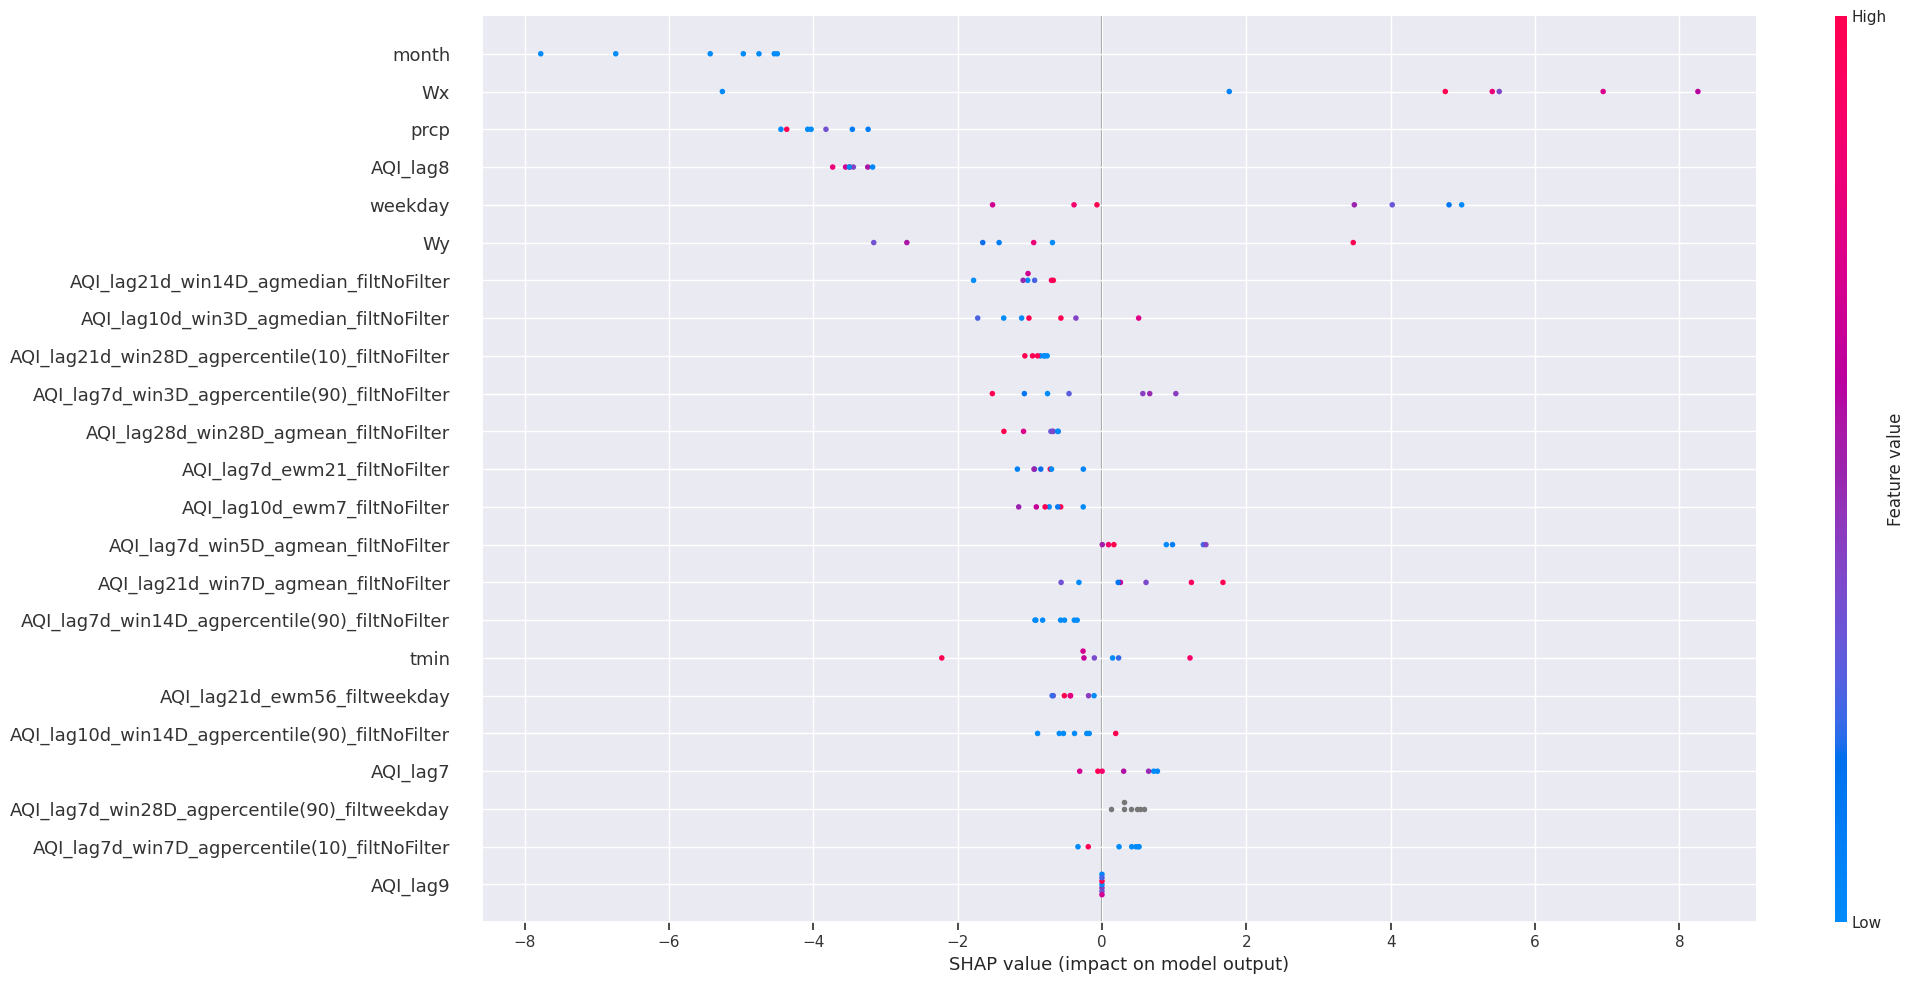

In [145]:
import shap
score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params, best_categories=best_categories, best_feat_count=best_features_count)

shap_values = shap.TreeExplainer(o_helper.best_model).shap_values(x_val)
shap.summary_plot(shap_values, x_val, plot_size=(21, 10), max_display=30)

In [142]:
score_train, score_val

(10.864539757018477, 14.553234164393642)

run_params_search n_trials=50, search_category=False, best_features_only=False, with_pruner=True


  0%|          | 0/50 [00:00<?, ?it/s]

Trial 3 finished with best value: 44.2969429406708 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2800, 'num_leaves': 72, 'learning_rate': 0.14949955871088502, 'subsample': 0.1658509810814539, 'subsample_freq': 1, 'subsample_for_bin': 320050, 'min_child_samples': 426, 'reg_alpha': 0.43227039487172836, 'reg_lambda': 0.33591093504561864, 'max_depth': 10, 'max_bin': 204}. 
Trial 1 finished with best value: 42.99828952710851 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1700, 'num_leaves': 76, 'learning_rate': 0.11239734038112167, 'subsample': 0.3779098907064199, 'subsample_freq': 6, 'subsample_for_bin': 81473, 'min_child_samples': 522, 'reg_alpha': 0.7706269498131296, 'reg_lambda': 0.5509865816009387, 'max_depth': 4, 'max_bin': 374}. 
Trial 8 finished with best value: 28.4843

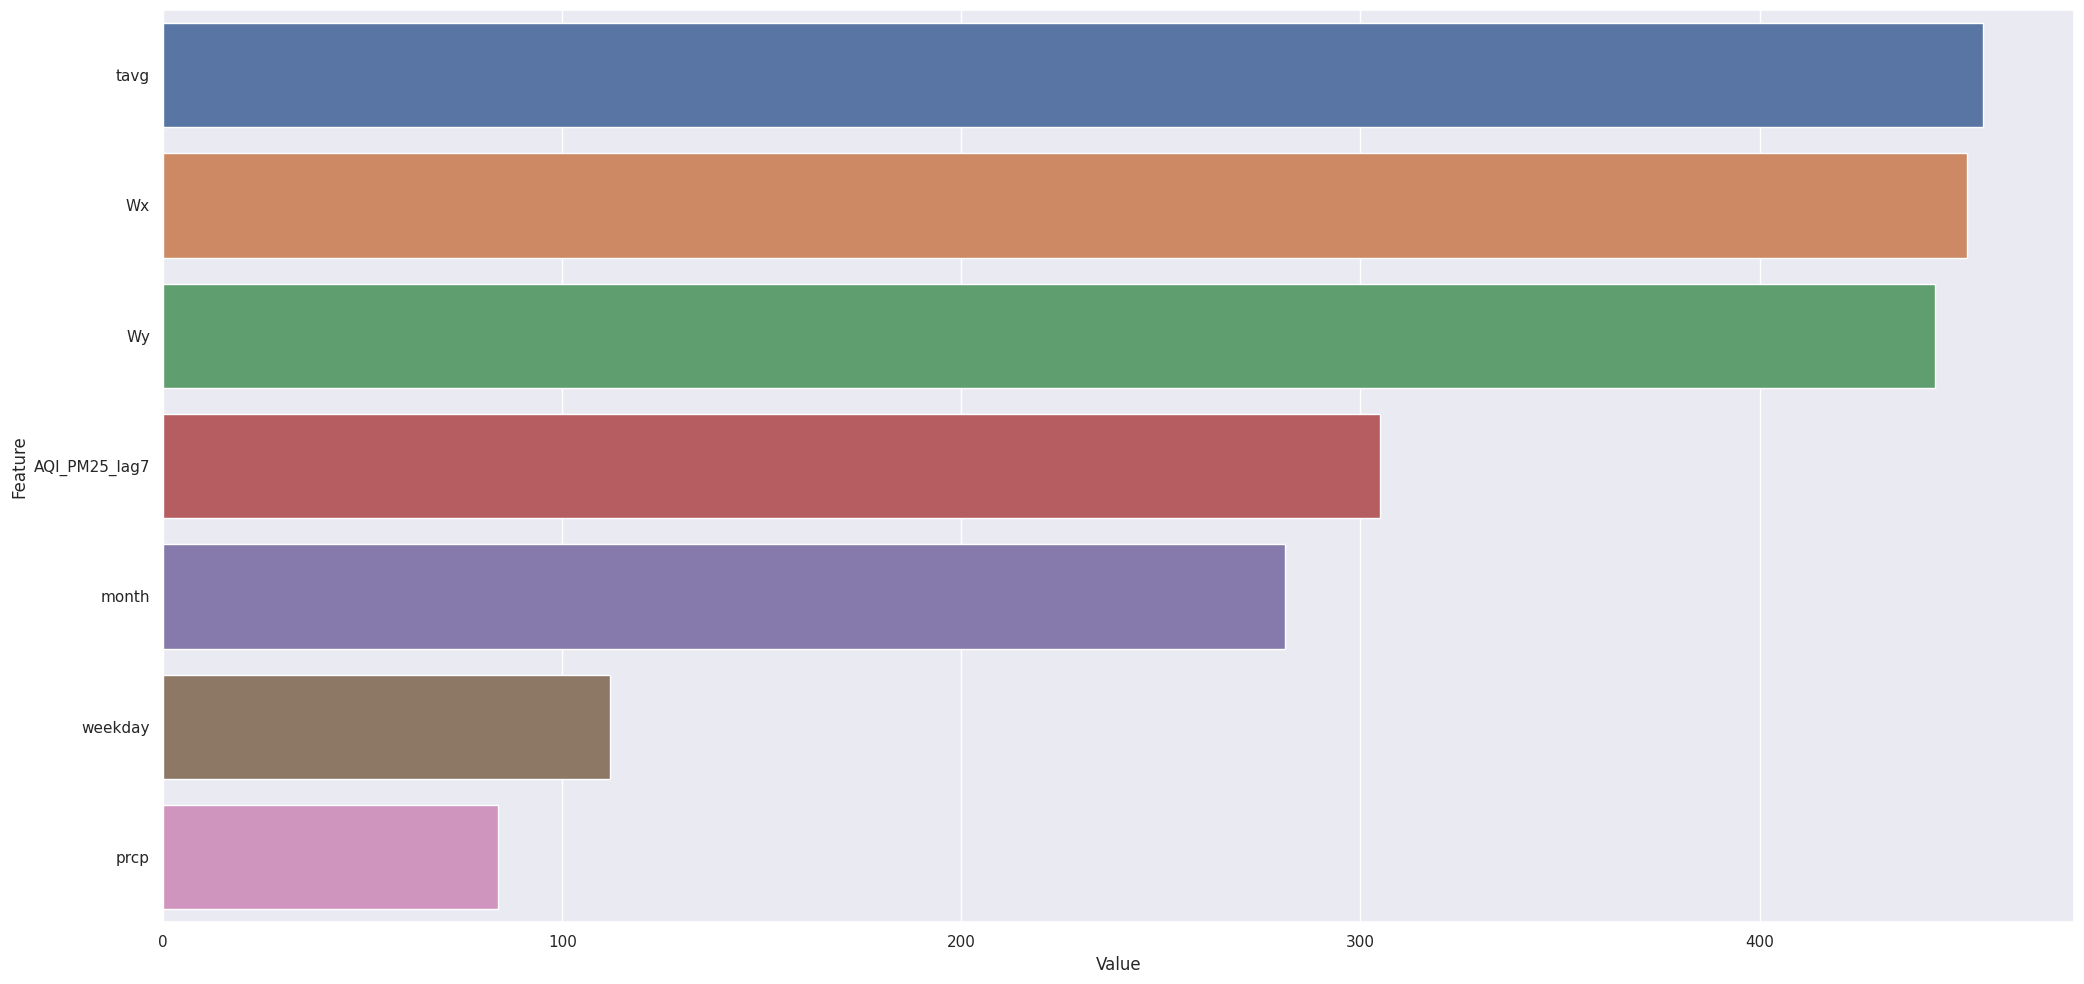

(10.589218512316585, 10.44503528534833, ['month', 'weekday'], 7)

In [99]:
default_category = ['month', 'weekday', ]
# ['AQI_PM25', 'month', 'weekday', 'tavg', 'Wx', 'Wy', 'prcp']
columns = ['AQI_PM25', 'month', 'weekday',  'tavg', 'Wx', 'Wy', 'prcp'] + \
    [
        'AQI_PM25_lag7',
        # 'AQI_PM25_lag8',
        # 'AQI_PM25_lag9'
    ] + \
          [
             #  'AQI_PM25_lag7d_win5D_agpctl10_filtNoFilter',
             # 'AQI_PM25_lag7d_win7D_agmean_filtNoFilter',
             # 'AQI_PM25_lag7d_ewm28_filtNoFilter'
          ]

TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint[columns], pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
               best_features_only=False, search_category=False, n_trials=50, n_jobs=8, df_filtered=True)
score_train, score_val, best_categories, best_features_count

In [103]:
best_params # AQI_PM25_lag7'

{'n_jobs': -1,
 'verbosity': -1,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'extra_trees': False,
 'n_estimators': 2200,
 'num_leaves': 109,
 'learning_rate': 0.09737386693705512,
 'subsample': 0.9199973407101166,
 'subsample_freq': 7,
 'subsample_for_bin': 267198,
 'min_child_samples': 62,
 'reg_alpha': 0.059189464180918513,
 'reg_lambda': 0.9387096728476719,
 'max_depth': 5,
 'max_bin': 350}

In [91]:
best_params # (AQI_PM25_lag7', + 3 gen )

{'n_jobs': -1,
 'verbosity': -1,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'extra_trees': True,
 'n_estimators': 2500,
 'num_leaves': 78,
 'learning_rate': 0.09344017511597268,
 'subsample': 0.8244073206586706,
 'subsample_freq': 8,
 'subsample_for_bin': 460982,
 'min_child_samples': 11,
 'reg_alpha': 0.2563341089135497,
 'reg_lambda': 0.8855384528289731,
 'max_depth': 11,
 'max_bin': 256}

In [102]:
TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-01-25'
VAL_DATE_FROM = '2023-01-26'
VAL_DATE_TO = '2023-02-02'

TRAIN_DATE_FROM = '2015-02-08'
TRAIN_DATE_TO = '2023-01-30'
VAL_DATE_FROM = '2023-01-31'
VAL_DATE_TO = '2023-02-06'

TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

score_train, score_val, y_pred, x_val, y_val, o_helper = get_prediction(
    df=df_joint[columns], pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols,
    use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
    best_params=best_params,
    best_categories=best_categories,
    best_feat_count=best_features_count)
score_train, score_val

(10.589218512316585, 10.445035285348332)